In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import joblib
import os
import io
import time
import xgboost as xgb
import lightgbm as lgb
import shap
import nbimporter


from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from time import time
from statsmodels.tsa.stattools import kpss
from plotnine import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Load the datasets
chýbajúci_zub = pd.read_csv('missing_tooth.csv')
odštiepený_zub = pd.read_csv('tooth_chipped_fault.csv')
povrchová_chyba = pd.read_csv('surface_fault.csv')
bez_poruchy = pd.read_csv('no_fault.csv')
koreňová_trhlina = pd.read_csv('root_crack.csv')
výstrednosť = pd.read_csv('eccentricity.csv')

In [4]:
chýbajúci_zub['Stav'] = 'chýbajúci_zub'
odštiepený_zub['Stav'] = 'odštiepený_zub'
povrchová_chyba['Stav'] = 'povrchová_chyba'
bez_poruchy['Stav'] = 'bez_poruchy'
koreňová_trhlina['Stav'] = 'koreňová_trhlina'
výstrednosť['Stav'] = 'výstrednosť'

df = pd.concat([
    bez_poruchy,
    chýbajúci_zub, 
    odštiepený_zub,
    povrchová_chyba,
    koreňová_trhlina, 
    výstrednosť
])

In [5]:
# save df.info to csv
info = df.info()
info = pd.DataFrame(info)
info.to_csv('df_info.csv')

<class 'pandas.core.frame.DataFrame'>
Index: 900000 entries, 0 to 149999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   sensor1          900000 non-null  float64
 1   sensor2          900000 non-null  float64
 2   time_x           900000 non-null  object 
 3   speedSet         900000 non-null  float64
 4   load_value       900000 non-null  int64  
 5   gear_fault_desc  900000 non-null  object 
 6   Stav             900000 non-null  object 
dtypes: float64(3), int64(1), object(3)
memory usage: 54.9+ MB


In [6]:
#Normalize time_x grouped by Stav, load_value, speedSet
df['time_x'] = pd.to_datetime(df['time_x'])
df['time_normalized'] = df.groupby(['Stav', 'load_value', 'speedSet'])['time_x'].transform(lambda x: (x - x.min()).dt.total_seconds())
df['formated_time'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [7]:
# Capture df.info() into a string buffer
buffer = io.StringIO()
df.info(buf=buffer)
info_string = buffer.getvalue()

# Save the string to a CSV file
with open('df_info.csv', 'w') as file:
    file.write(info_string)

In [8]:
#I need df describe for all by each 'Stav' columns
df_describe = df.groupby('Stav').describe().T
df_describe.to_csv('df_describe.csv')

In [9]:
df['formated_time'] = pd.to_datetime(df.time_x, format="%Y-%m-%d %H:%M:%S.%f")

In [10]:
# Define the variables before using them
speedload_8_0 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 0)].copy()
speedload_8_80 = df[(df['speedSet'] == 8.33203125) & (df['load_value'] == 80)].copy()
speedload_25_0 = df[(df['speedSet'] == 25) & (df['load_value'] == 0)].copy()
speedload_25_80 = df[(df['speedSet'] == 25) & (df['load_value'] == 80)].copy()
speedload_40_0 = df[(df['speedSet'] == 40) & (df['load_value'] == 0)].copy()
speedload_40_80 = df[(df['speedSet'] == 40) & (df['load_value'] == 80)].copy()

In [11]:
# Apply the KPSS test to each unique Stav for 'sensor1' values by 'normalized_time'.
def apply_kpss(series):
    kpss_stat, p_value, lags, crit = kpss(series, 'c')
    return kpss_stat, p_value, crit

# Apply the KPSS test to all unique states
unique_states = speedload_8_0['Stav'].unique()
kpss_results = {}
for Stav in unique_states:
    # Extracting the time series data for 'sensor1' for the current Stav
    time_series = speedload_8_0.loc[speedload_8_0['Stav'] == Stav, 'sensor1']
    # Applying KPSS test
    kpss_stat, p_value, crit = apply_kpss(time_series)
    kpss_results[Stav] = (kpss_stat, p_value, crit)

# You can print out the results or convert it to a DataFrame
kpss_results_df = pd.DataFrame(kpss_results, index=['KPSS Štatistica', 'p-hodnota', 'Kritické hodnoty']).T
print(kpss_results_df)

                 KPSS Štatistica p-hodnota  \
bez_poruchy             2.016985      0.01   
chýbajúci_zub           0.098826       0.1   
odštiepený_zub          3.135916      0.01   
povrchová_chyba         0.374733  0.088046   
koreňová_trhlina        9.098141      0.01   
výstrednosť             1.742396      0.01   

                                                   Kritické hodnoty  
bez_poruchy       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
chýbajúci_zub     {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
odštiepený_zub    {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
povrchová_chyba   {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
koreňová_trhlina  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  
výstrednosť       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%...  


C:\Users\rober\AppData\Local\Temp\ipykernel_17964\1512715864.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_17964\1512715864.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_17964\1512715864.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_17964\1512715864.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

C:\Users\rober\AppData\Local\Temp\ipykernel_17964\1512715864.py:

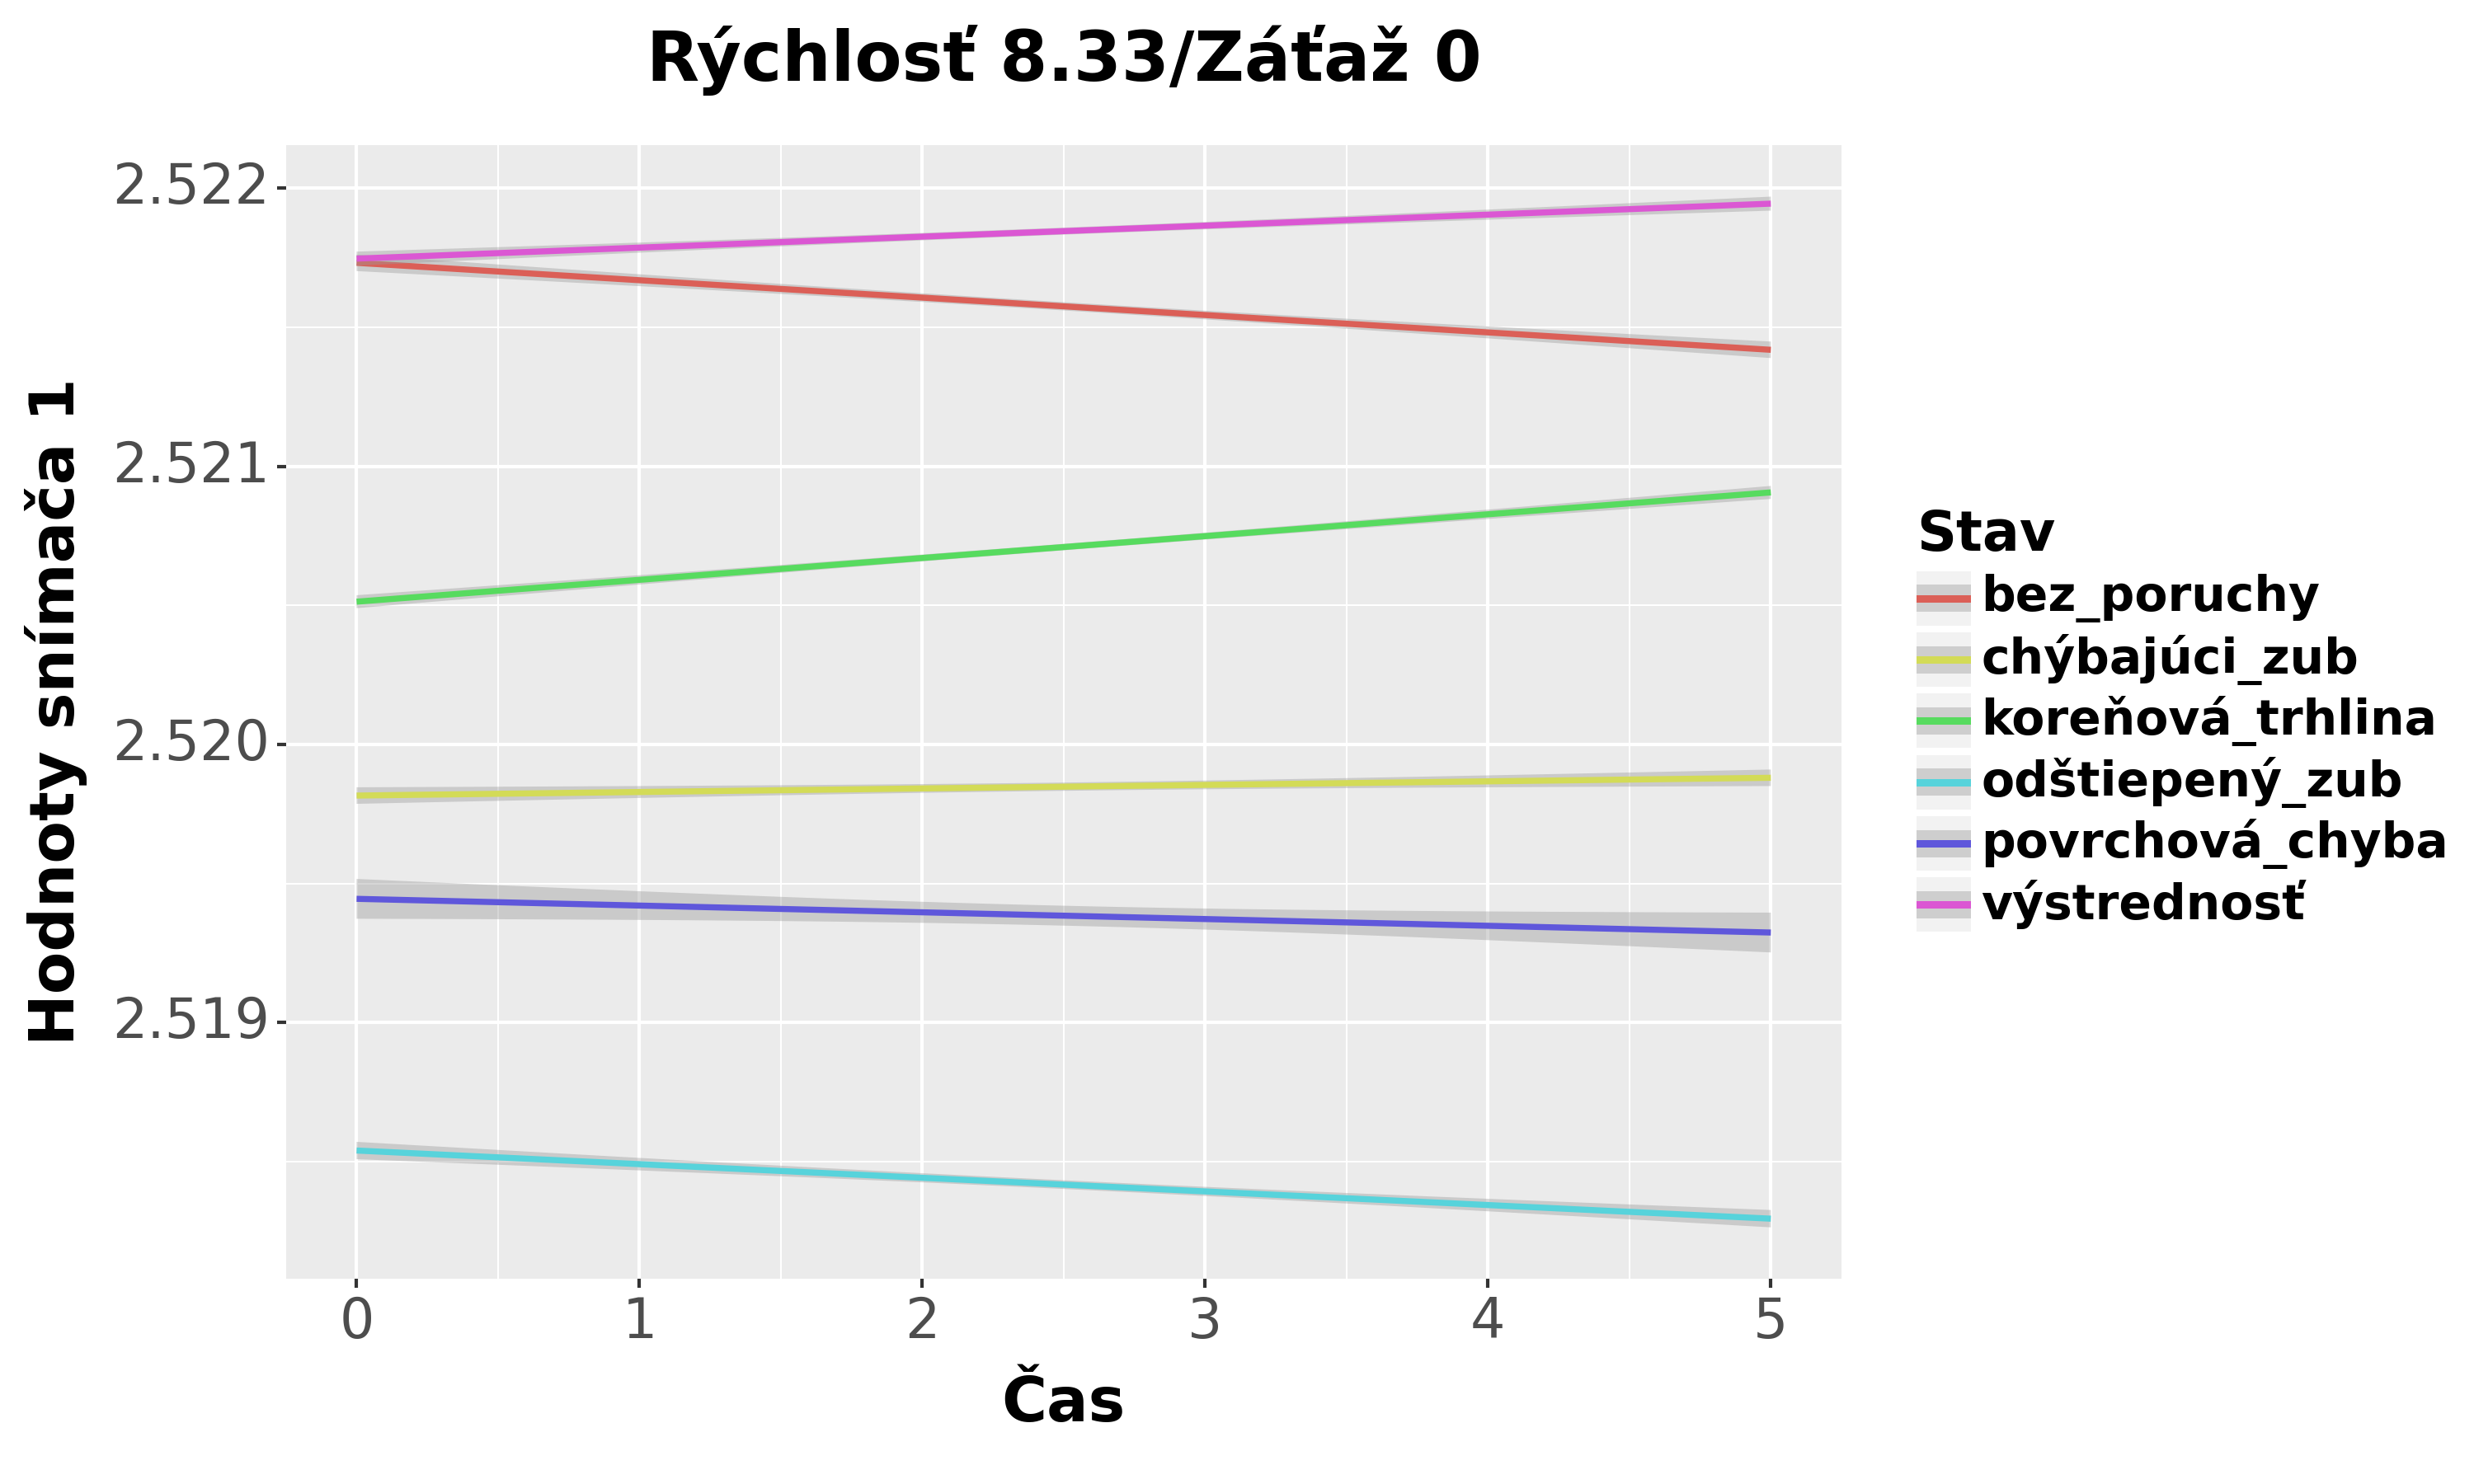

<Figure Size: (1500 x 900)>

<Figure Size: (1500 x 900)>

In [12]:
display(ggplot(data=speedload_8_0, mapping=aes(x='time_normalized', y='sensor1', color='Stav')) + geom_smooth() + 
        ggtitle('Rýchlosť 8.33/Záťaž 0') +
        labs(x='Čas', y='Hodnoty snímača 1', fill='Stav') +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_40_80, mapping=aes(x='time_normalized', y='sensor2', color='Stav')) + geom_smooth() + 
        ggtitle('Rýchlosť 40/Záťaž 80') +
        labs(x='Čas', y='Hodnoty snímača 2', fill='Stav') +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 473 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 473 rows containing non-finite values.


<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 462 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 462 rows containing non-finite values.


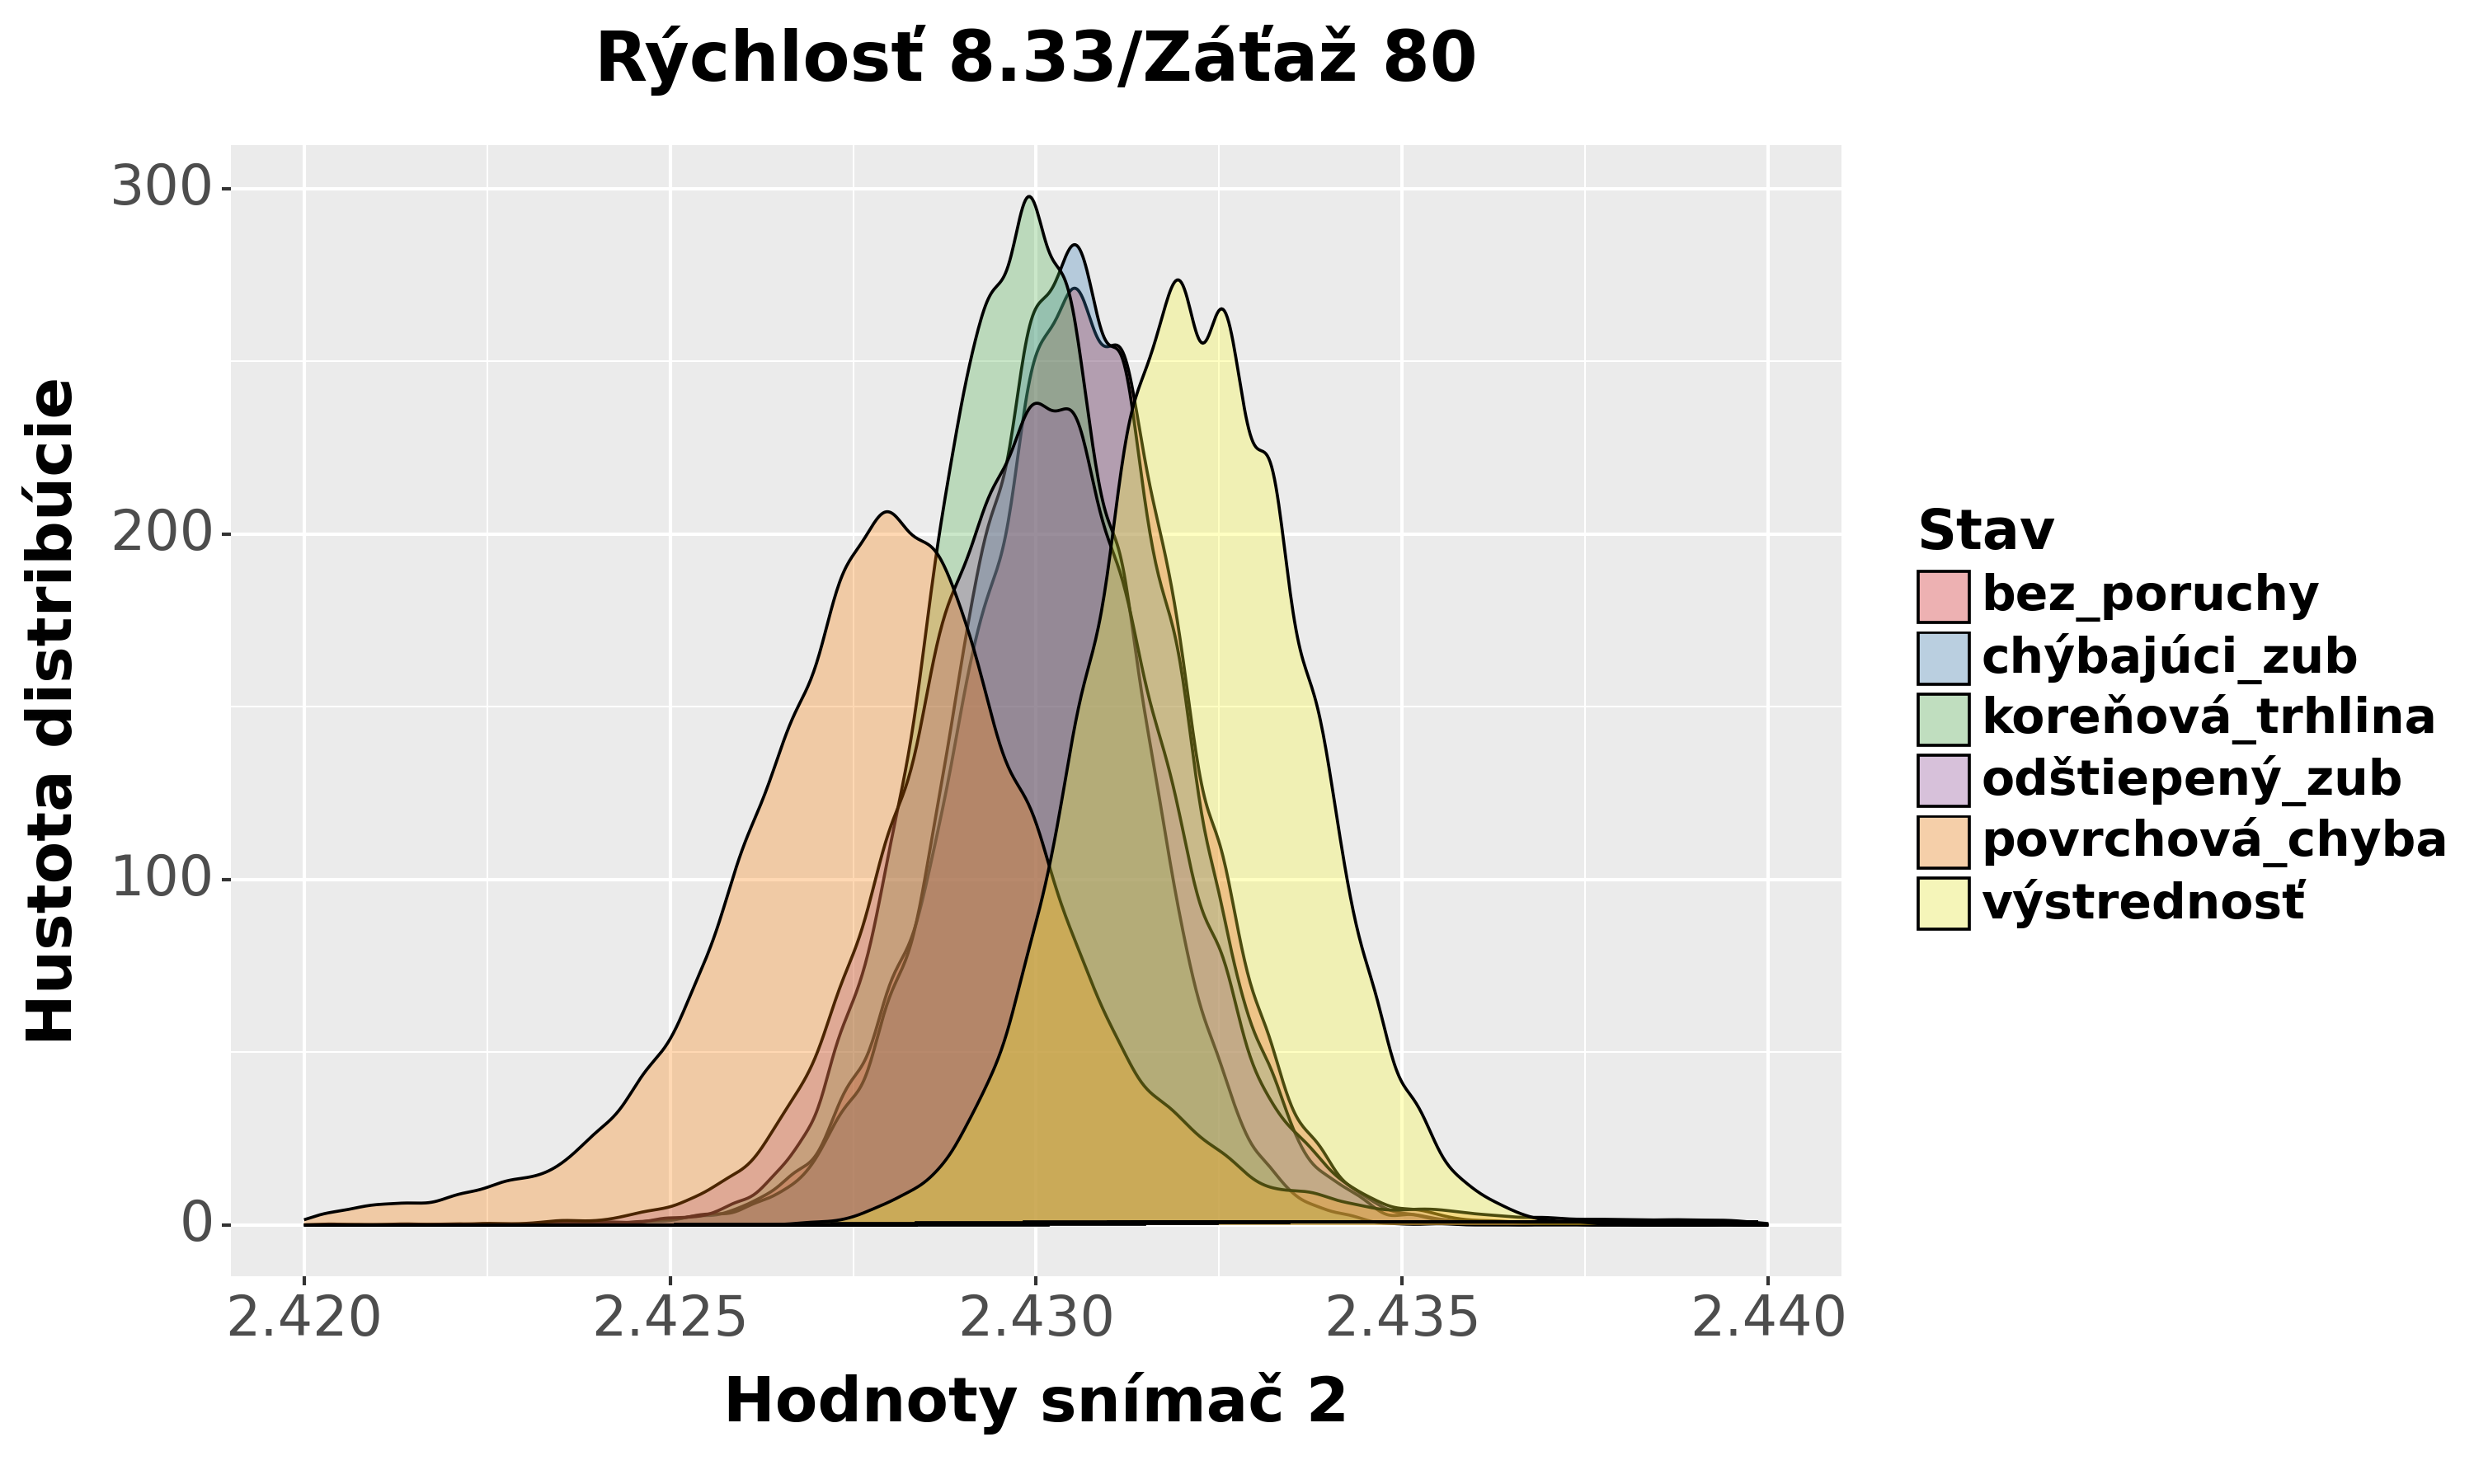

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 909 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 909 rows containing non-finite values.


<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 2404 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 2404 rows containing non-finite values.


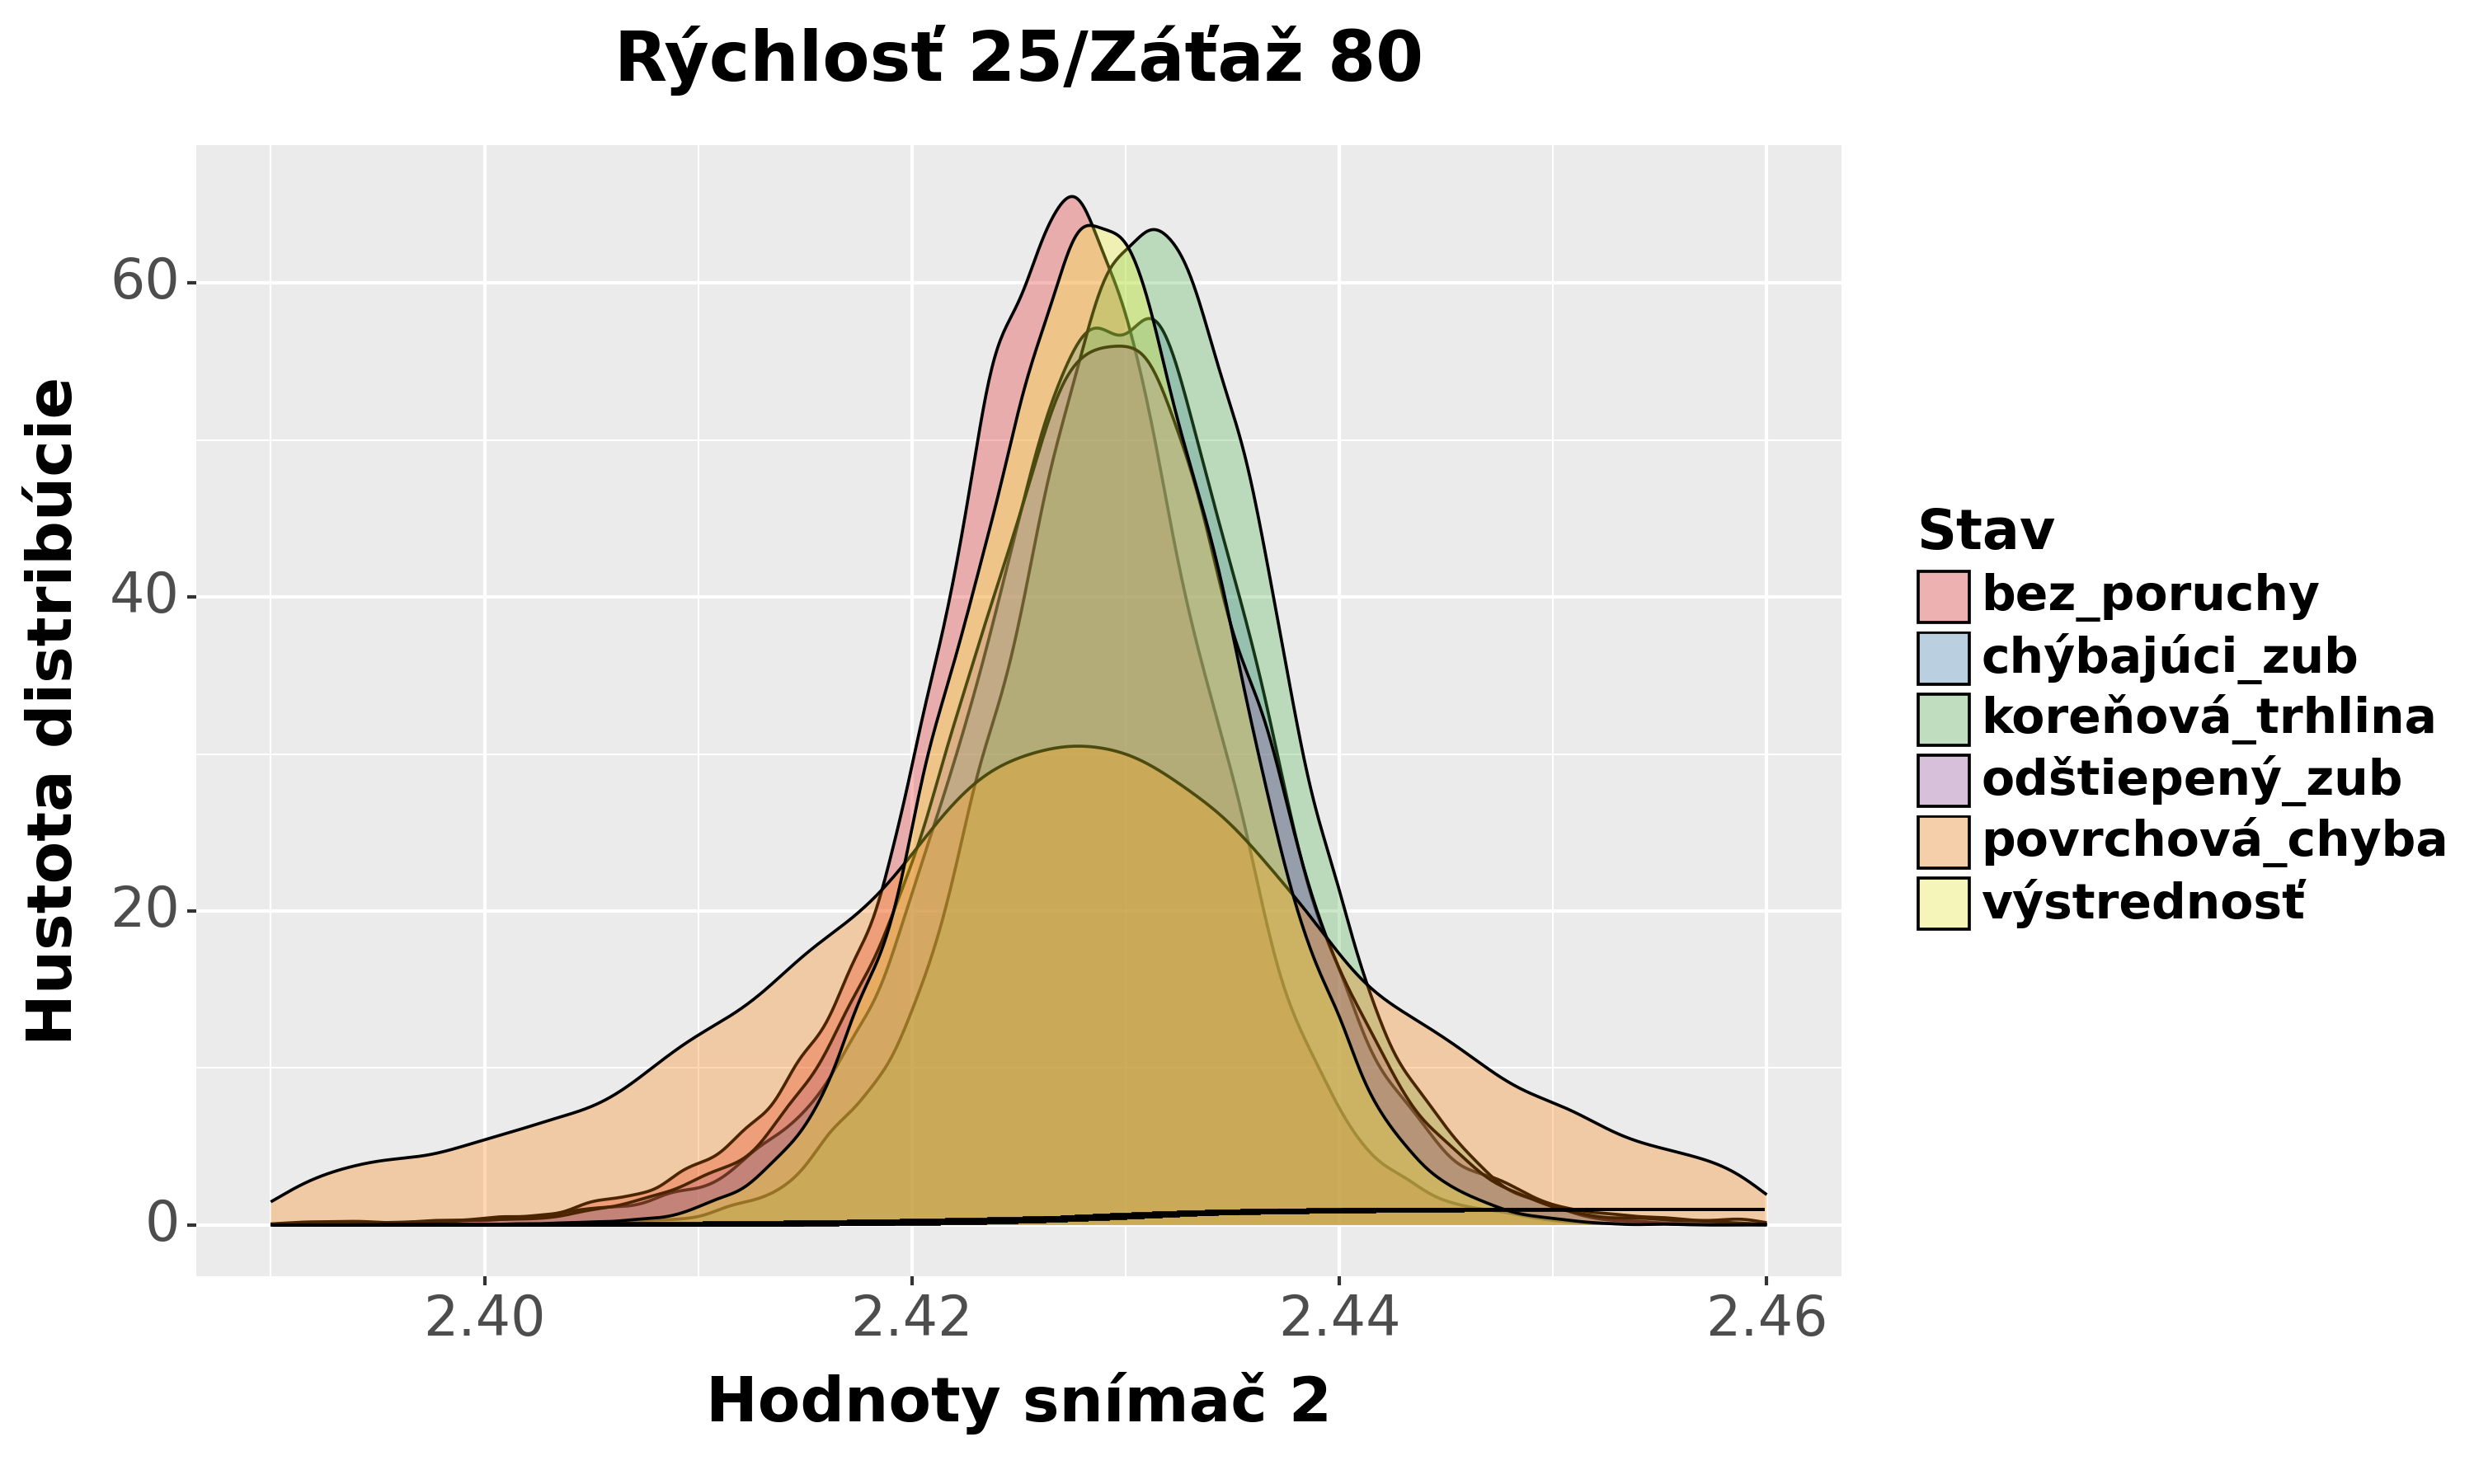

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 399 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 399 rows containing non-finite values.


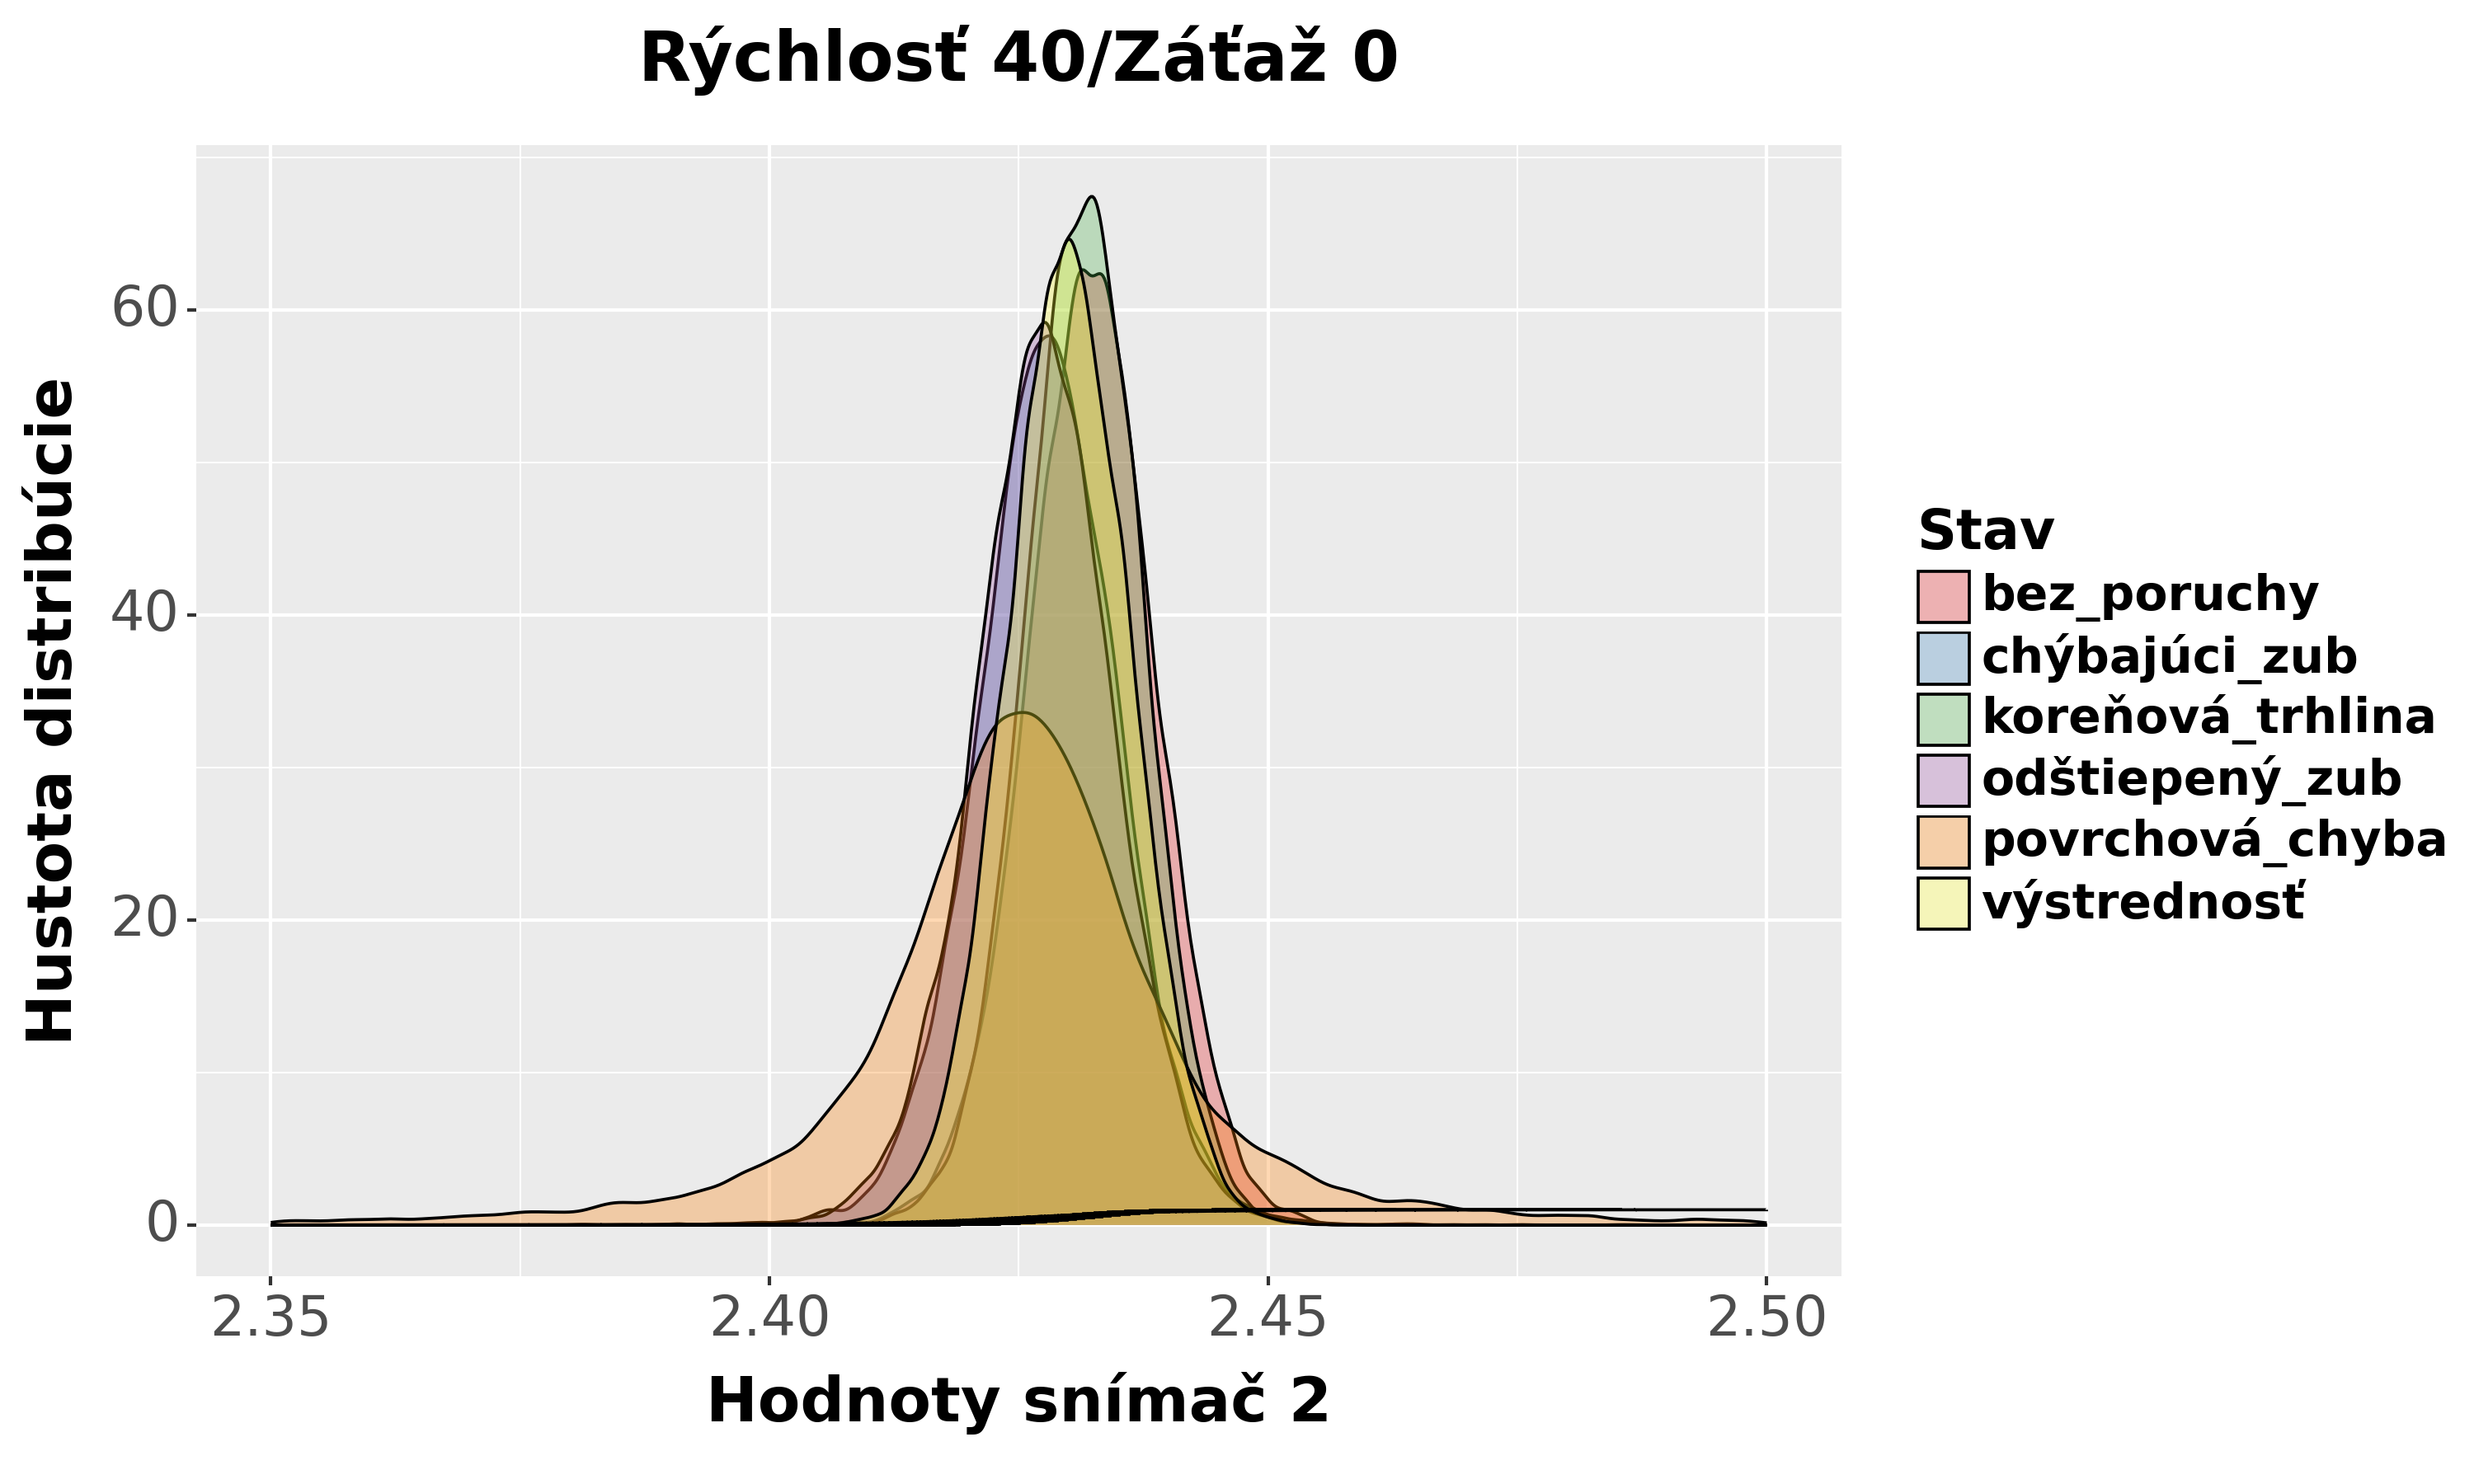

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 2915 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 2915 rows containing non-finite values.


<Figure Size: (1500 x 900)>

In [13]:
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']

display(ggplot(data=speedload_8_0, mapping=aes(x='sensor2', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 0') +
        labs(x='Hodnoty snímač 2', y='Hustota distribúcie', fill='Stav') + xlim(2.42,2.44) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_8_80, mapping=aes(x='sensor2', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 80') +
        labs(x='Hodnoty snímač 2', y='Hustota distribúcie', fill='Stav') + xlim(2.42,2.44) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_25_0, mapping=aes(x='sensor2', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25/Záťaž 0') +
        labs(x='Hodnoty snímač 2', y='Hustota distribúcie', fill='Stav') + xlim(2.39,2.46) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_25_80, mapping=aes(x='sensor2', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25/Záťaž 80') +
        labs(x='Hodnoty snímač 2', y='Hustota distribúcie', fill='Stav') + xlim(2.39,2.46) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_40_0, mapping=aes(x='sensor2', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40/Záťaž 0') +
        labs(x='Hodnoty snímač 2', y='Hustota distribúcie', fill='Stav') + xlim(2.35,2.5) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_40_80, mapping=aes(x='sensor2', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40/Záťaž 80') +
        labs(x='Hodnoty snímač 2', y='Hustota distribúcie', fill='Stav') + xlim(2.35,2.5) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 385 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 385 rows containing non-finite values.


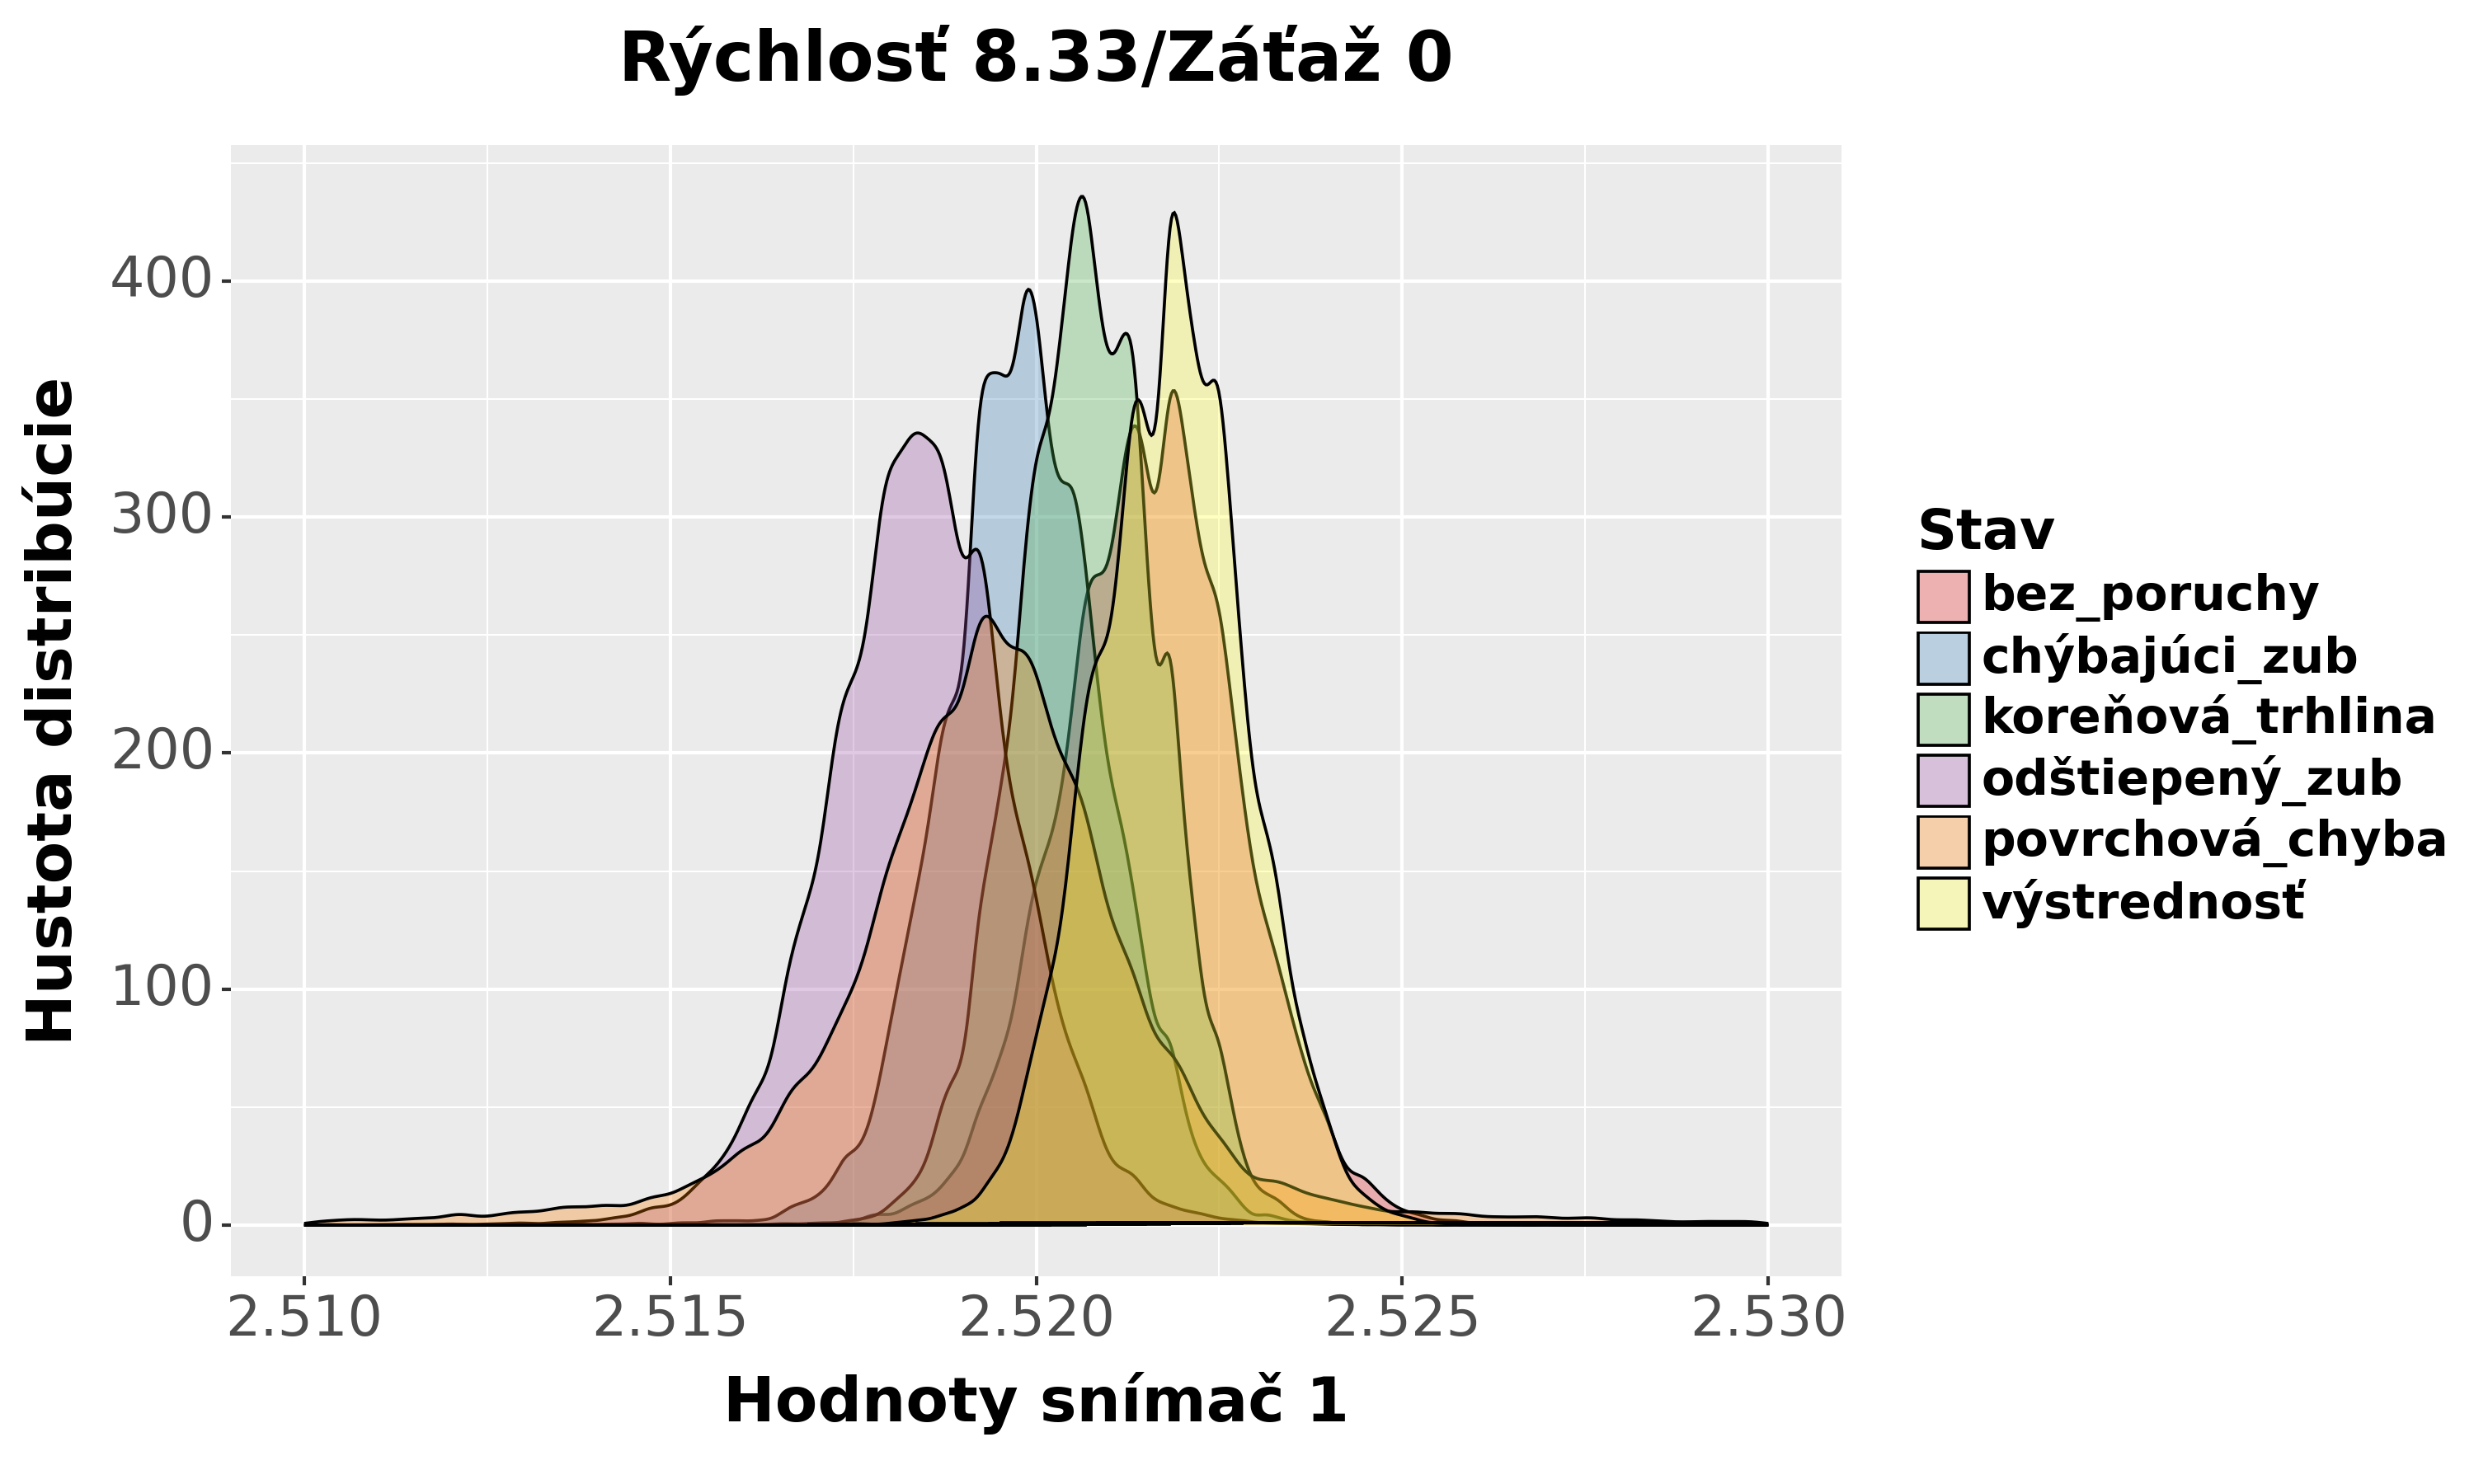

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 583 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 583 rows containing non-finite values.


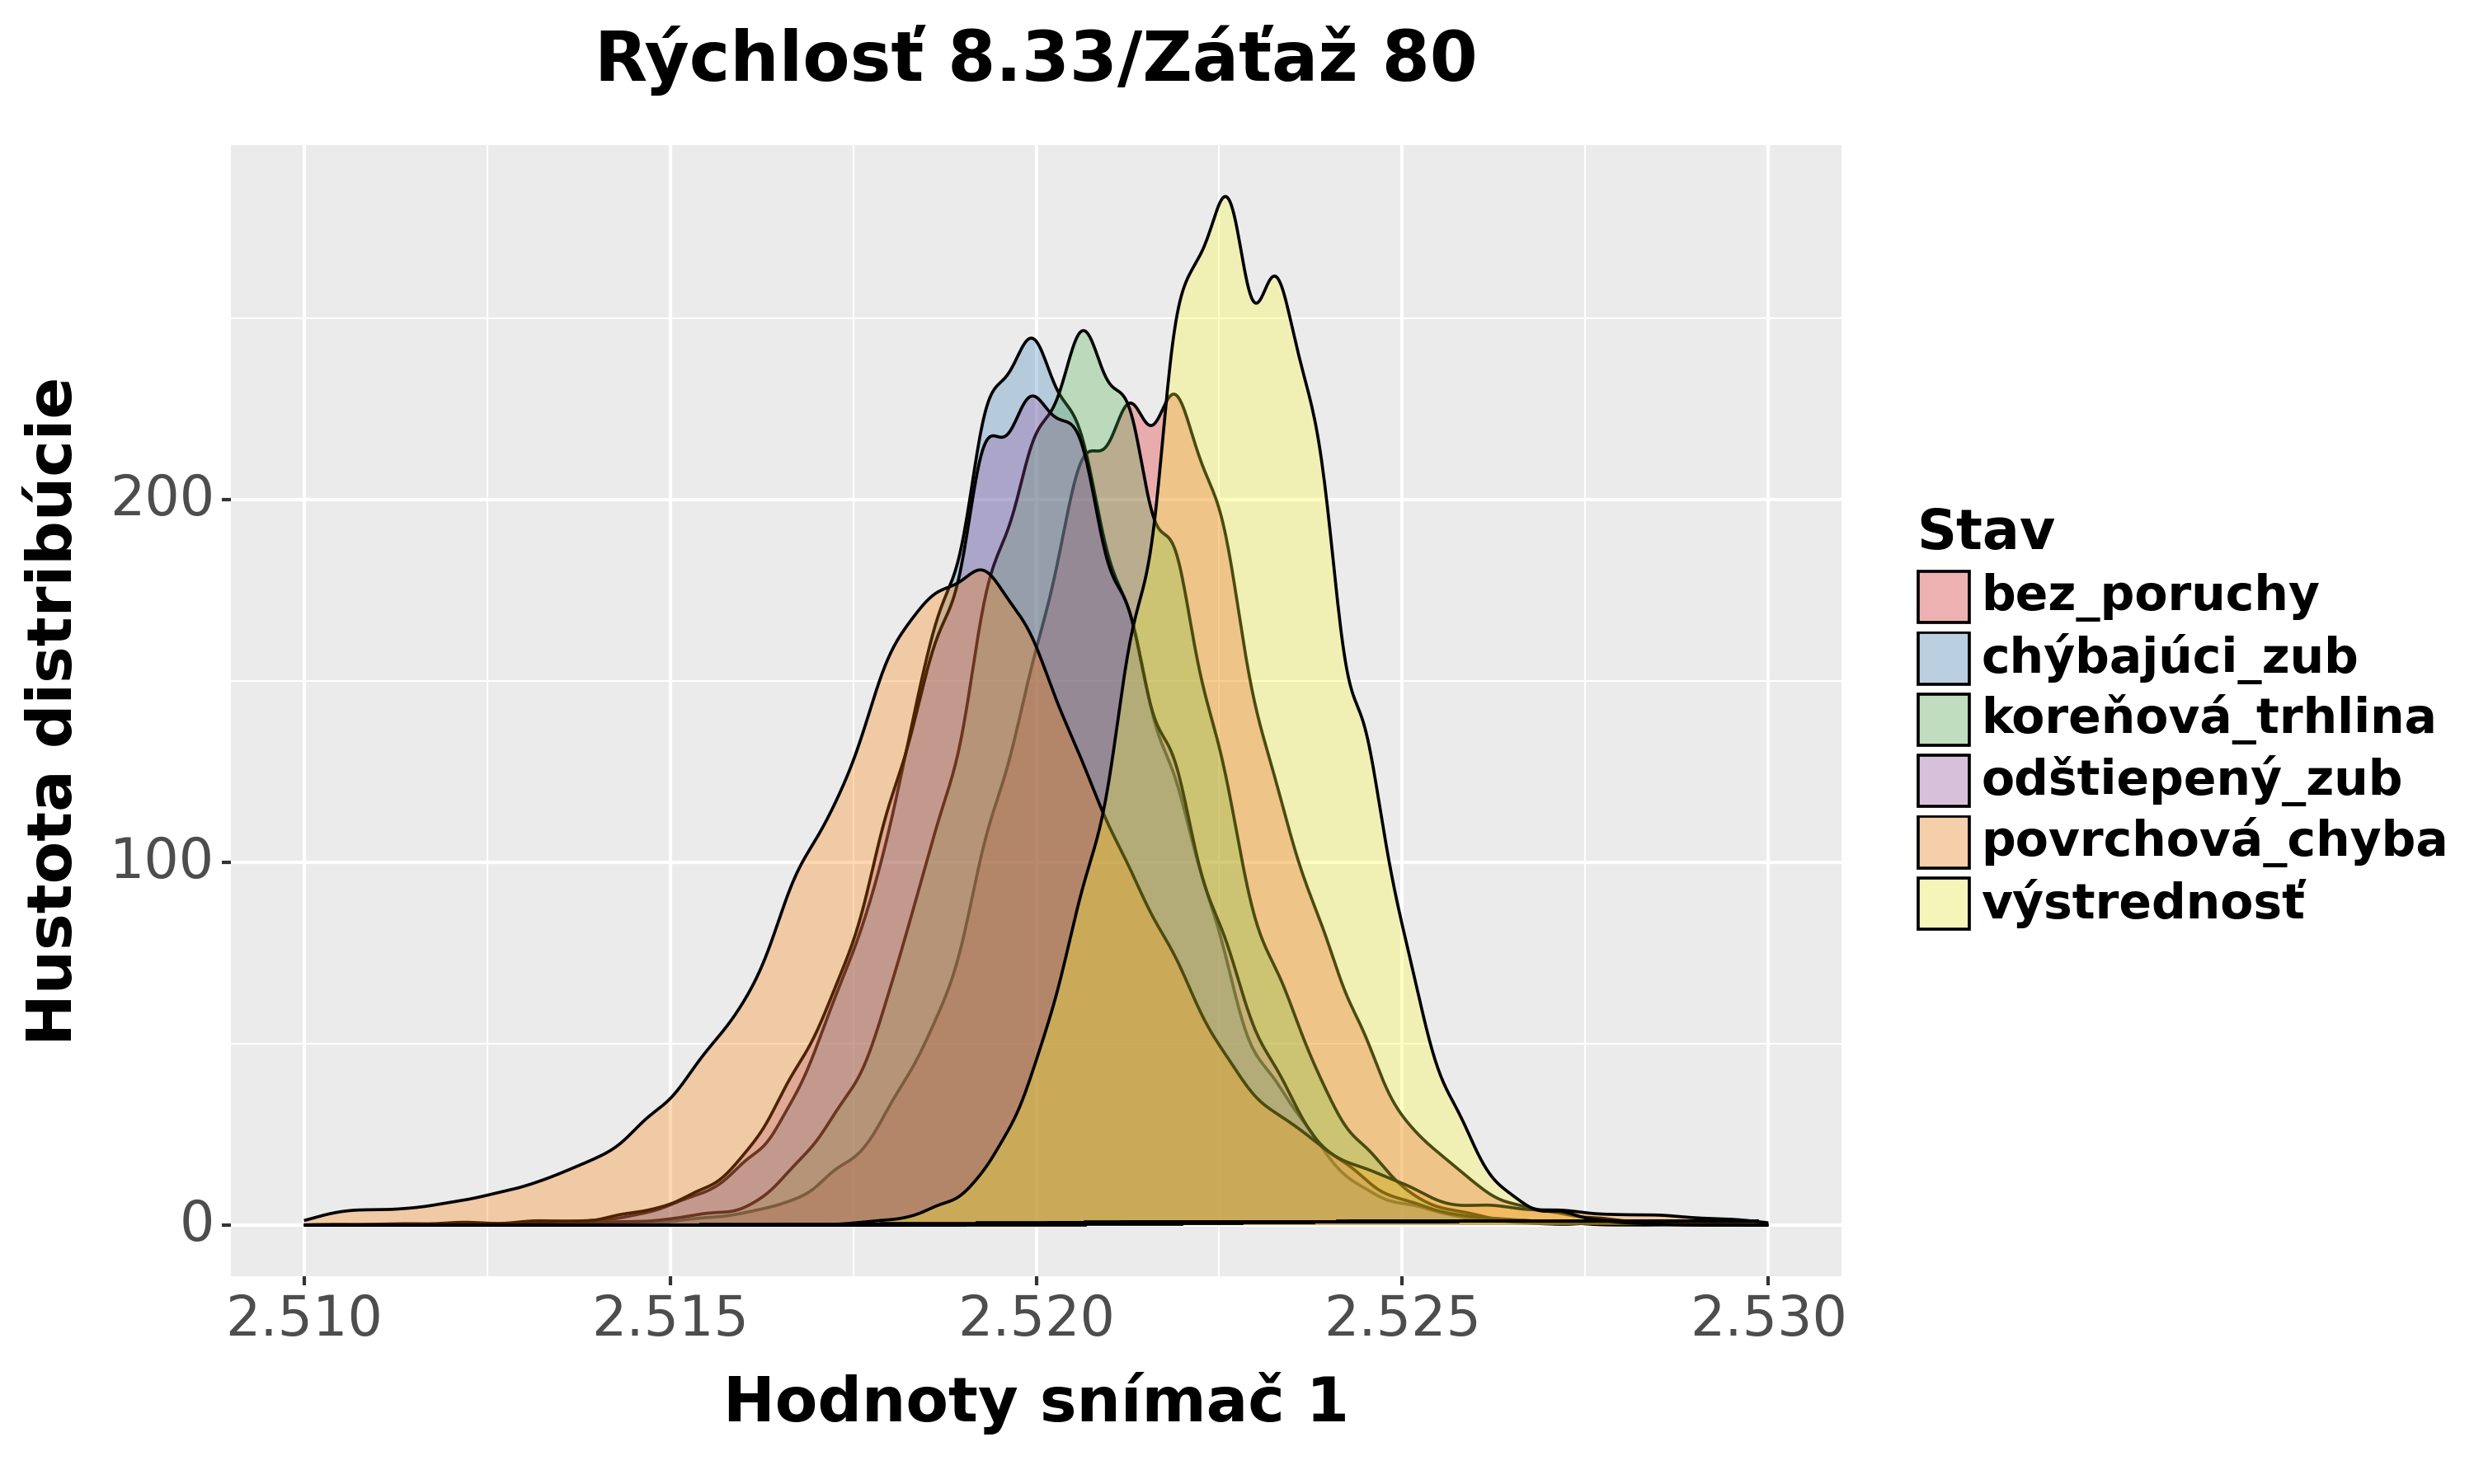

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 2093 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 2093 rows containing non-finite values.


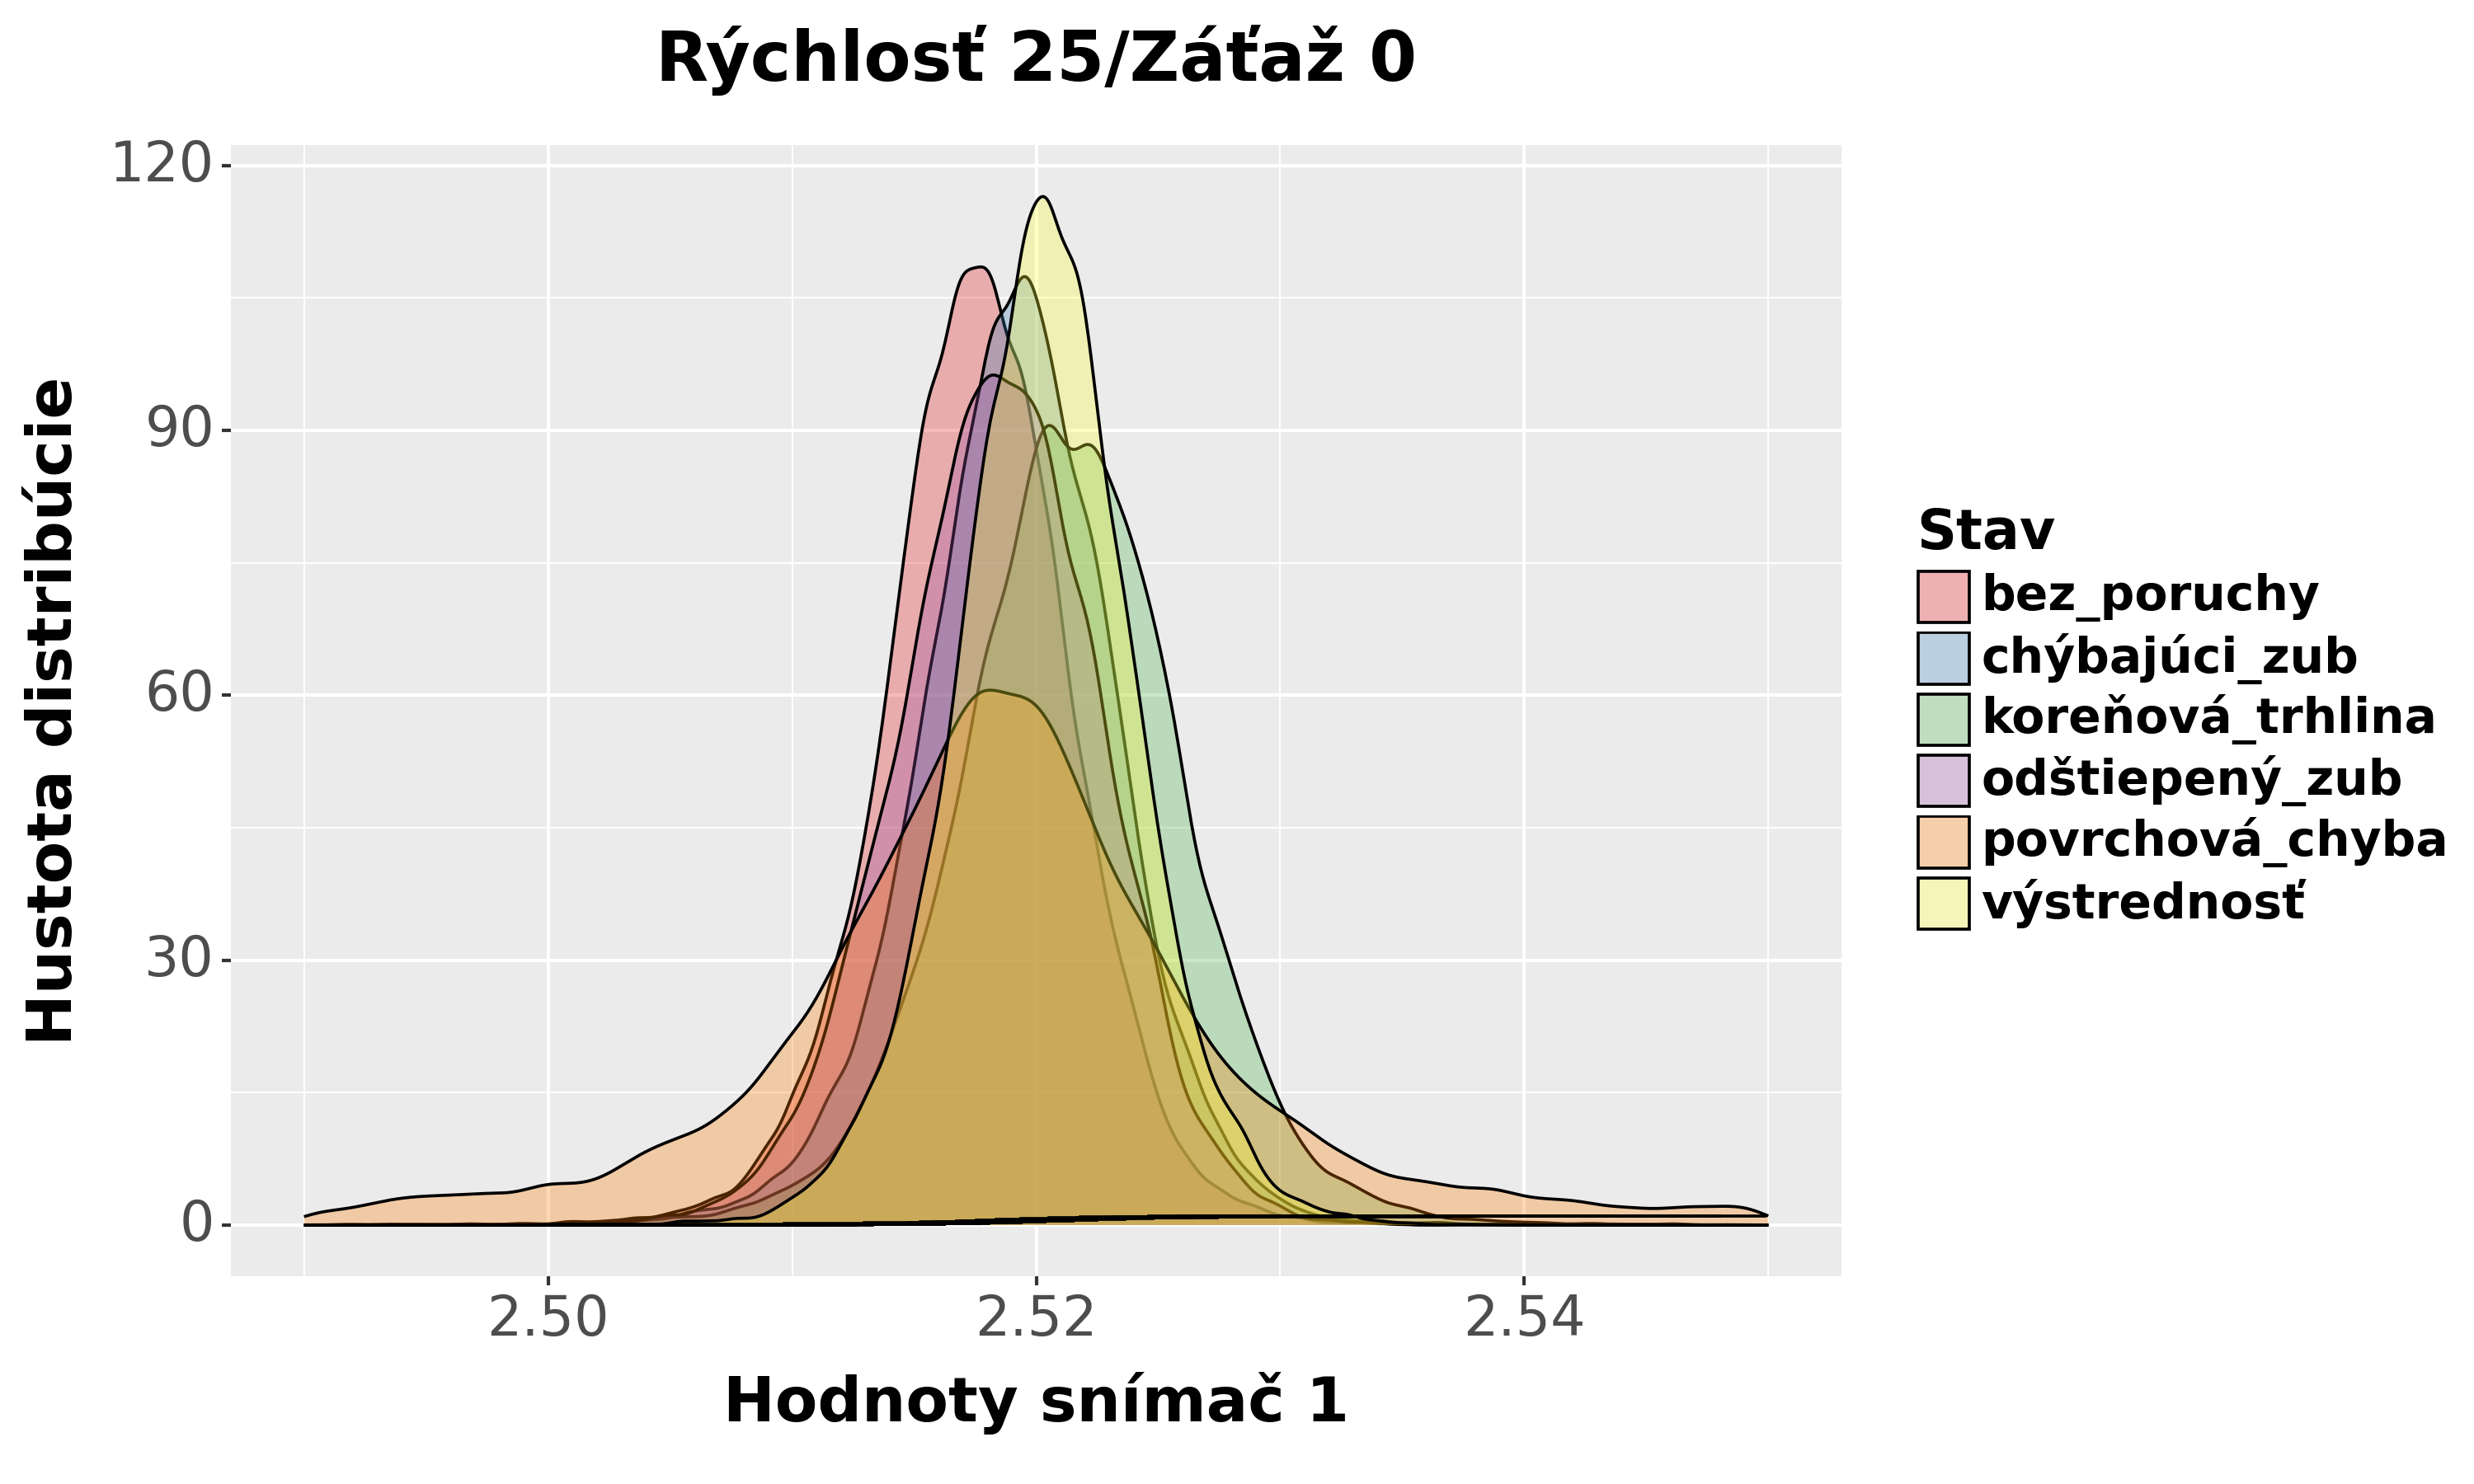

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 4918 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 4918 rows containing non-finite values.


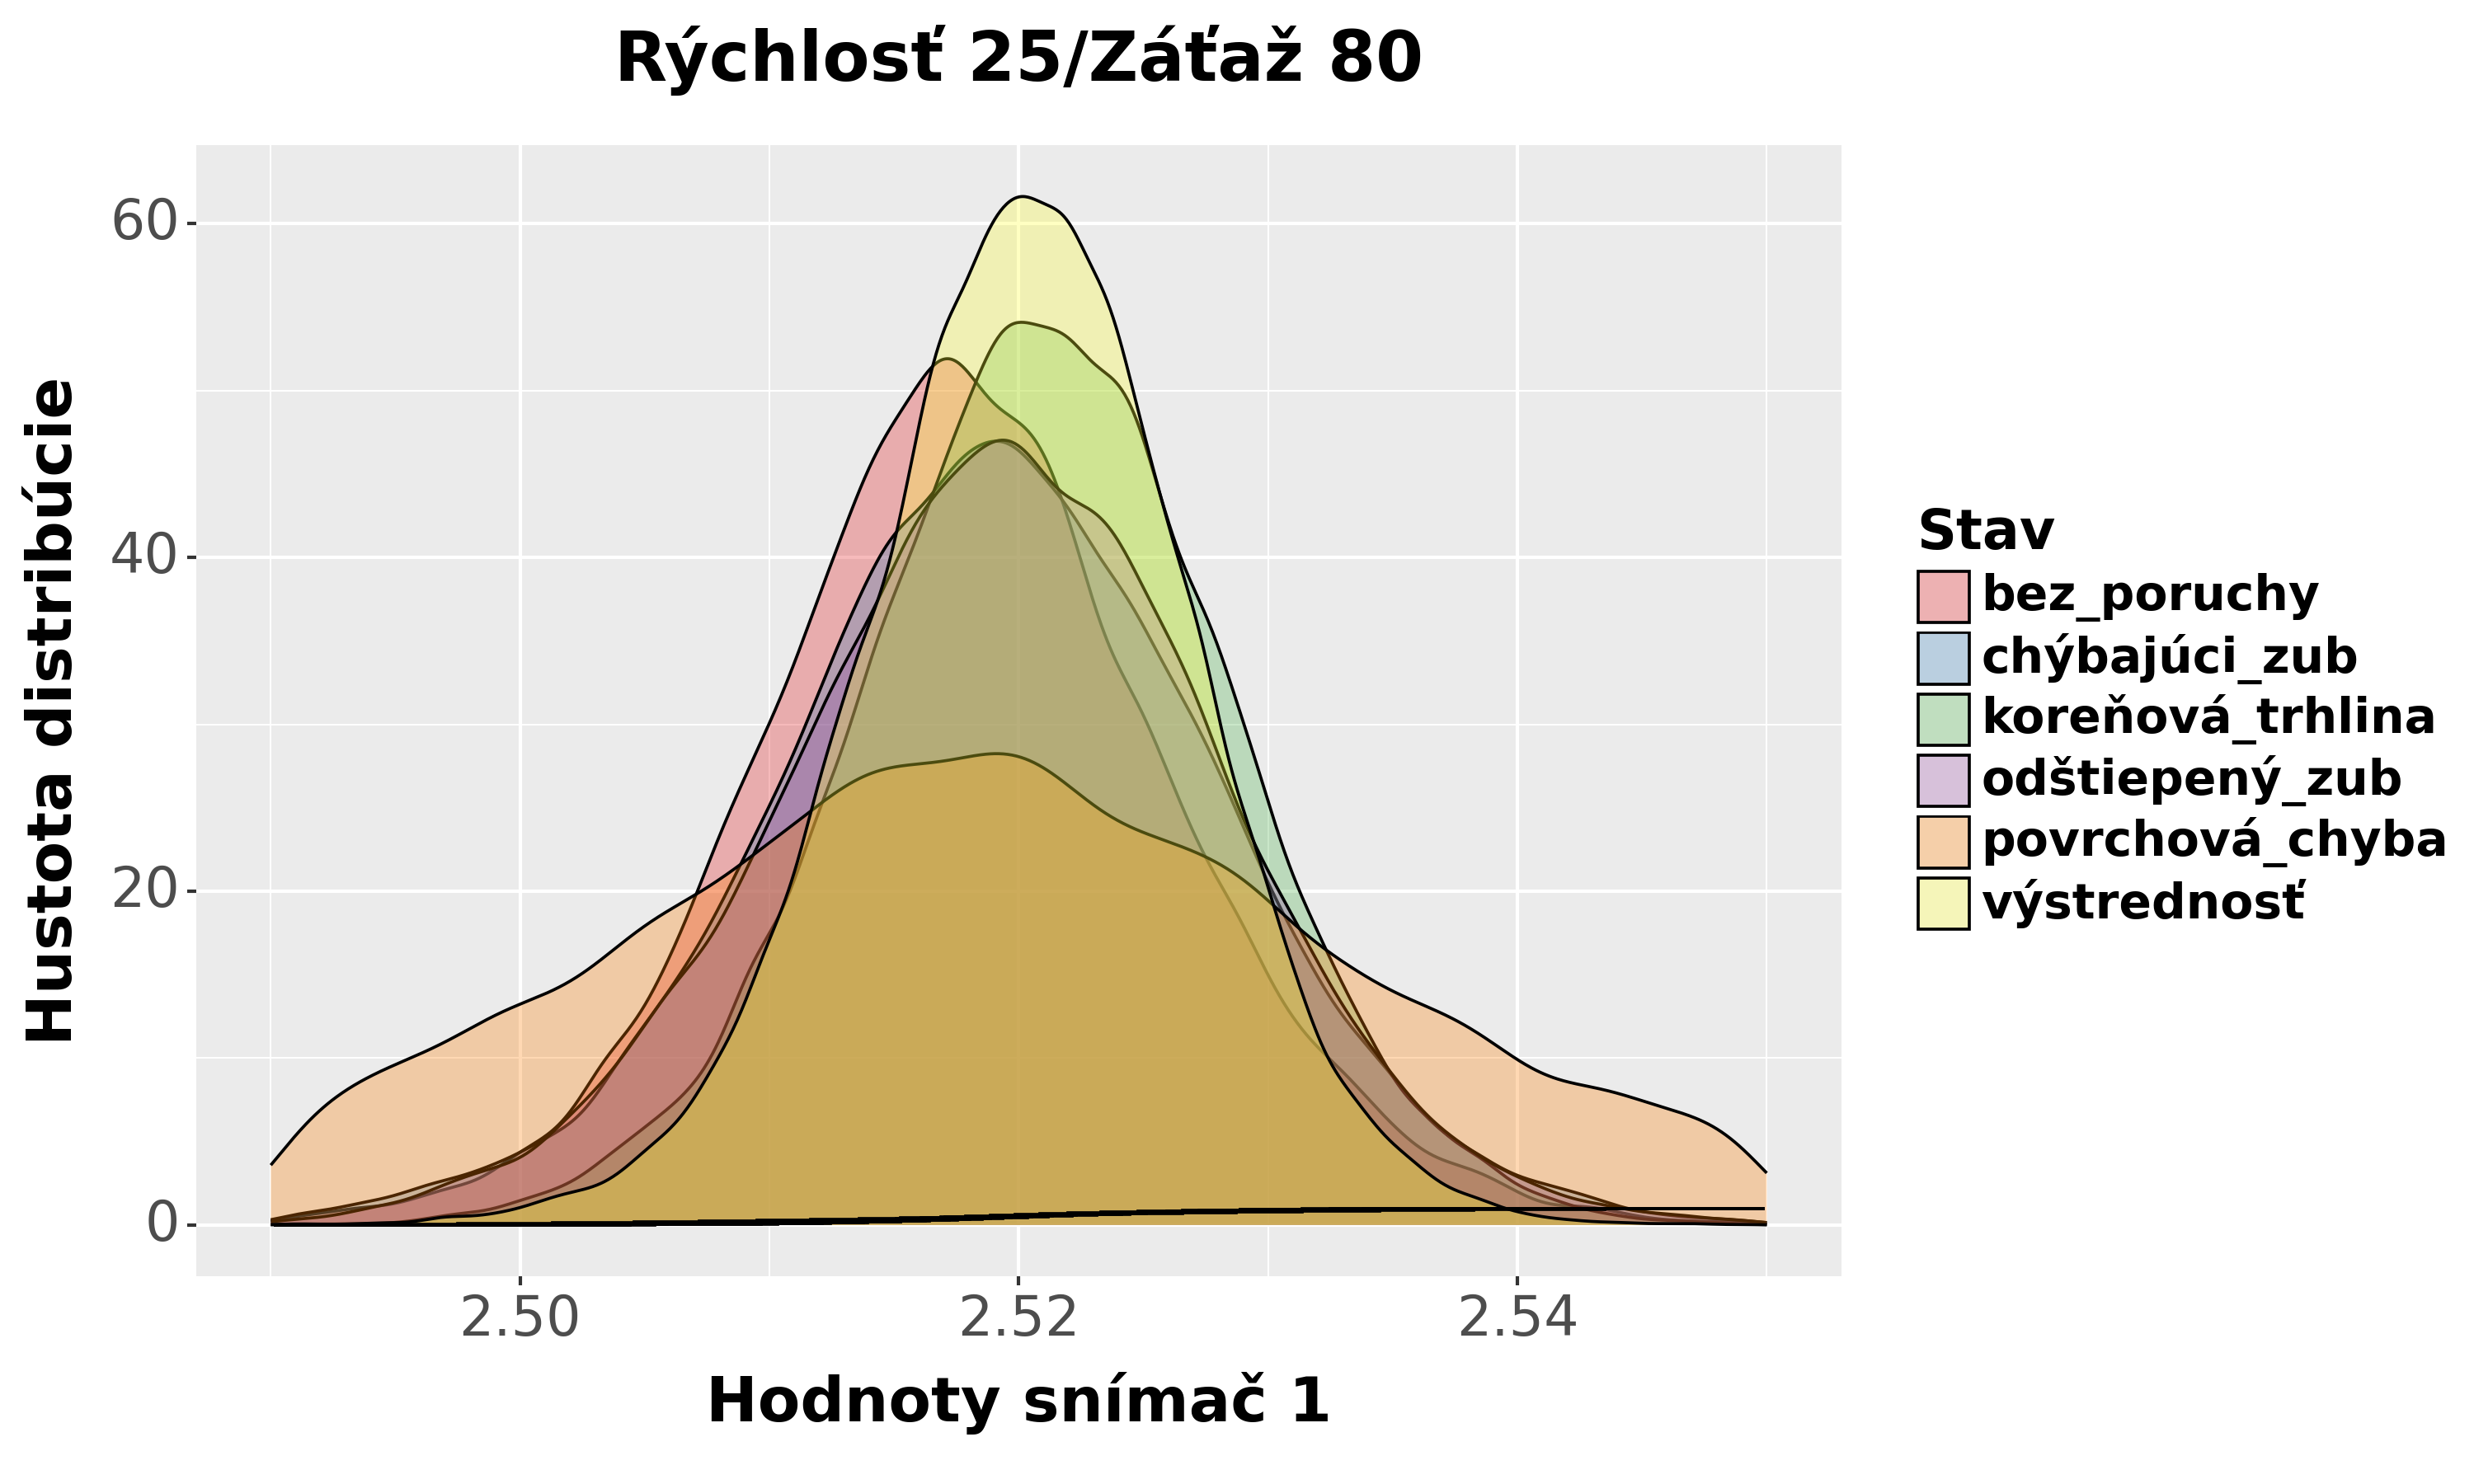

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 157 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 157 rows containing non-finite values.


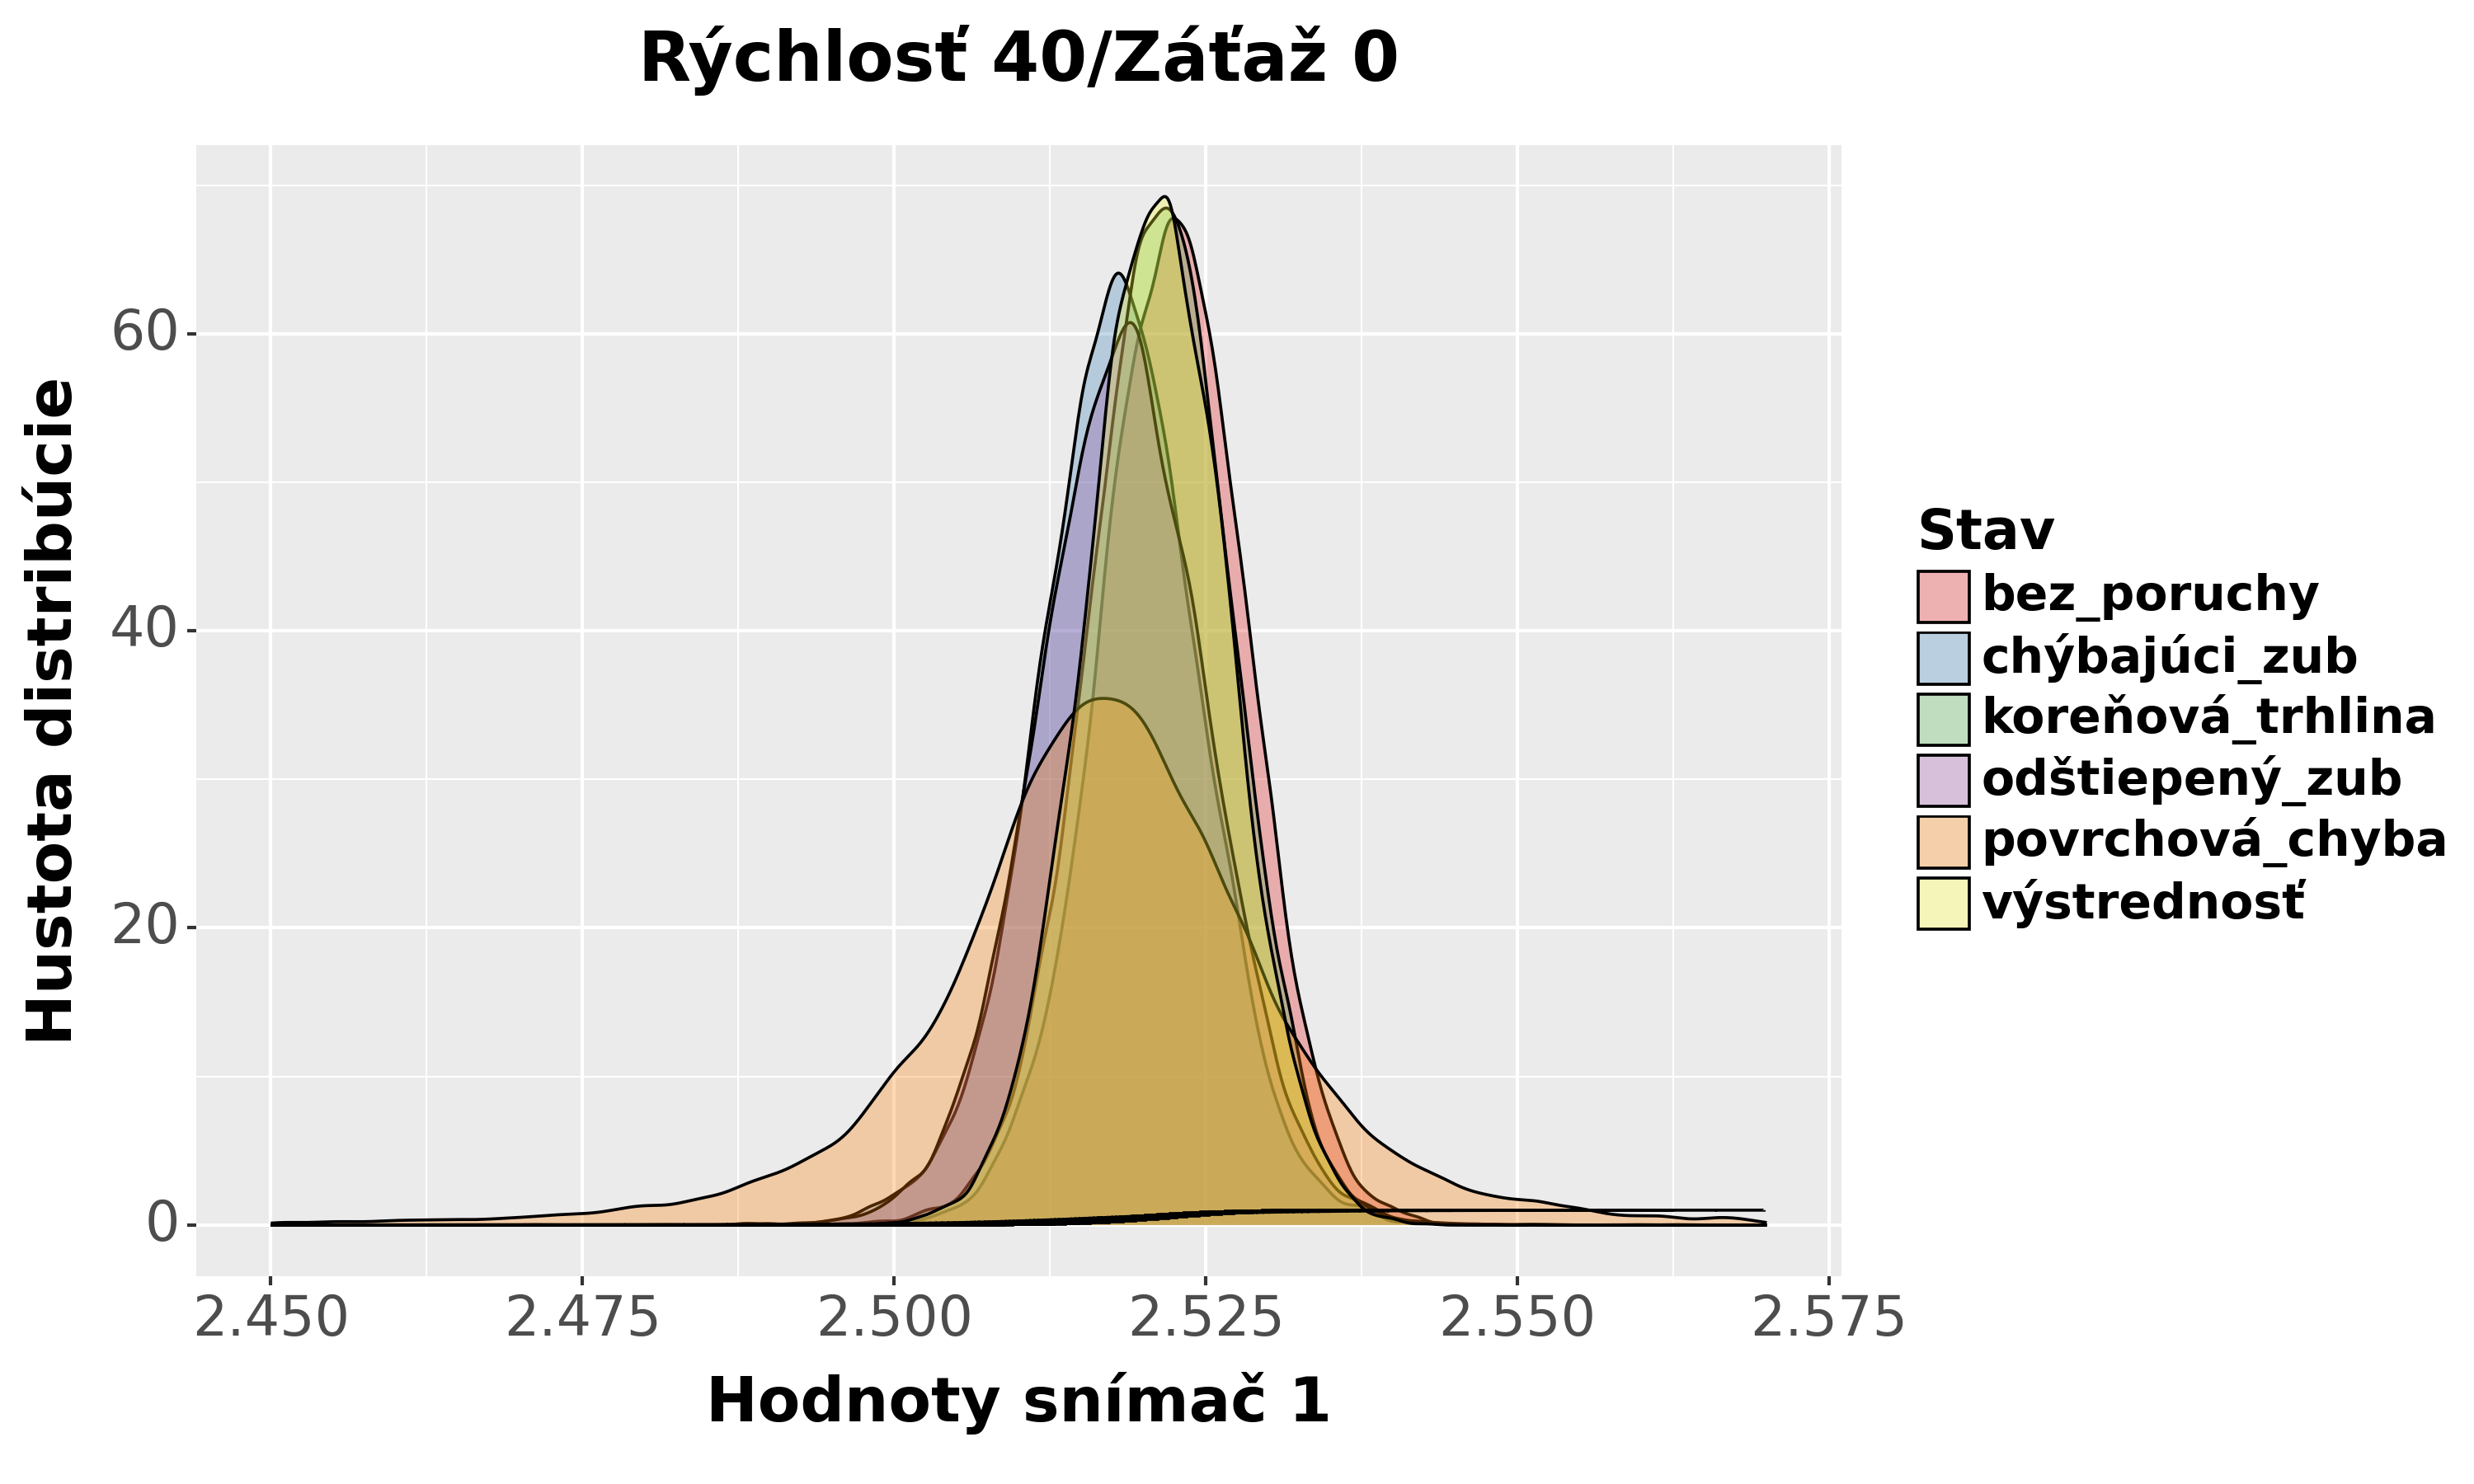

<Figure Size: (1500 x 900)>

c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_density : Removed 2480 rows containing non-finite values.
c:\Environments\shared_env\lib\site-packages\plotnine\layer.py:284: PlotnineWarning: stat_ecdf : Removed 2480 rows containing non-finite values.


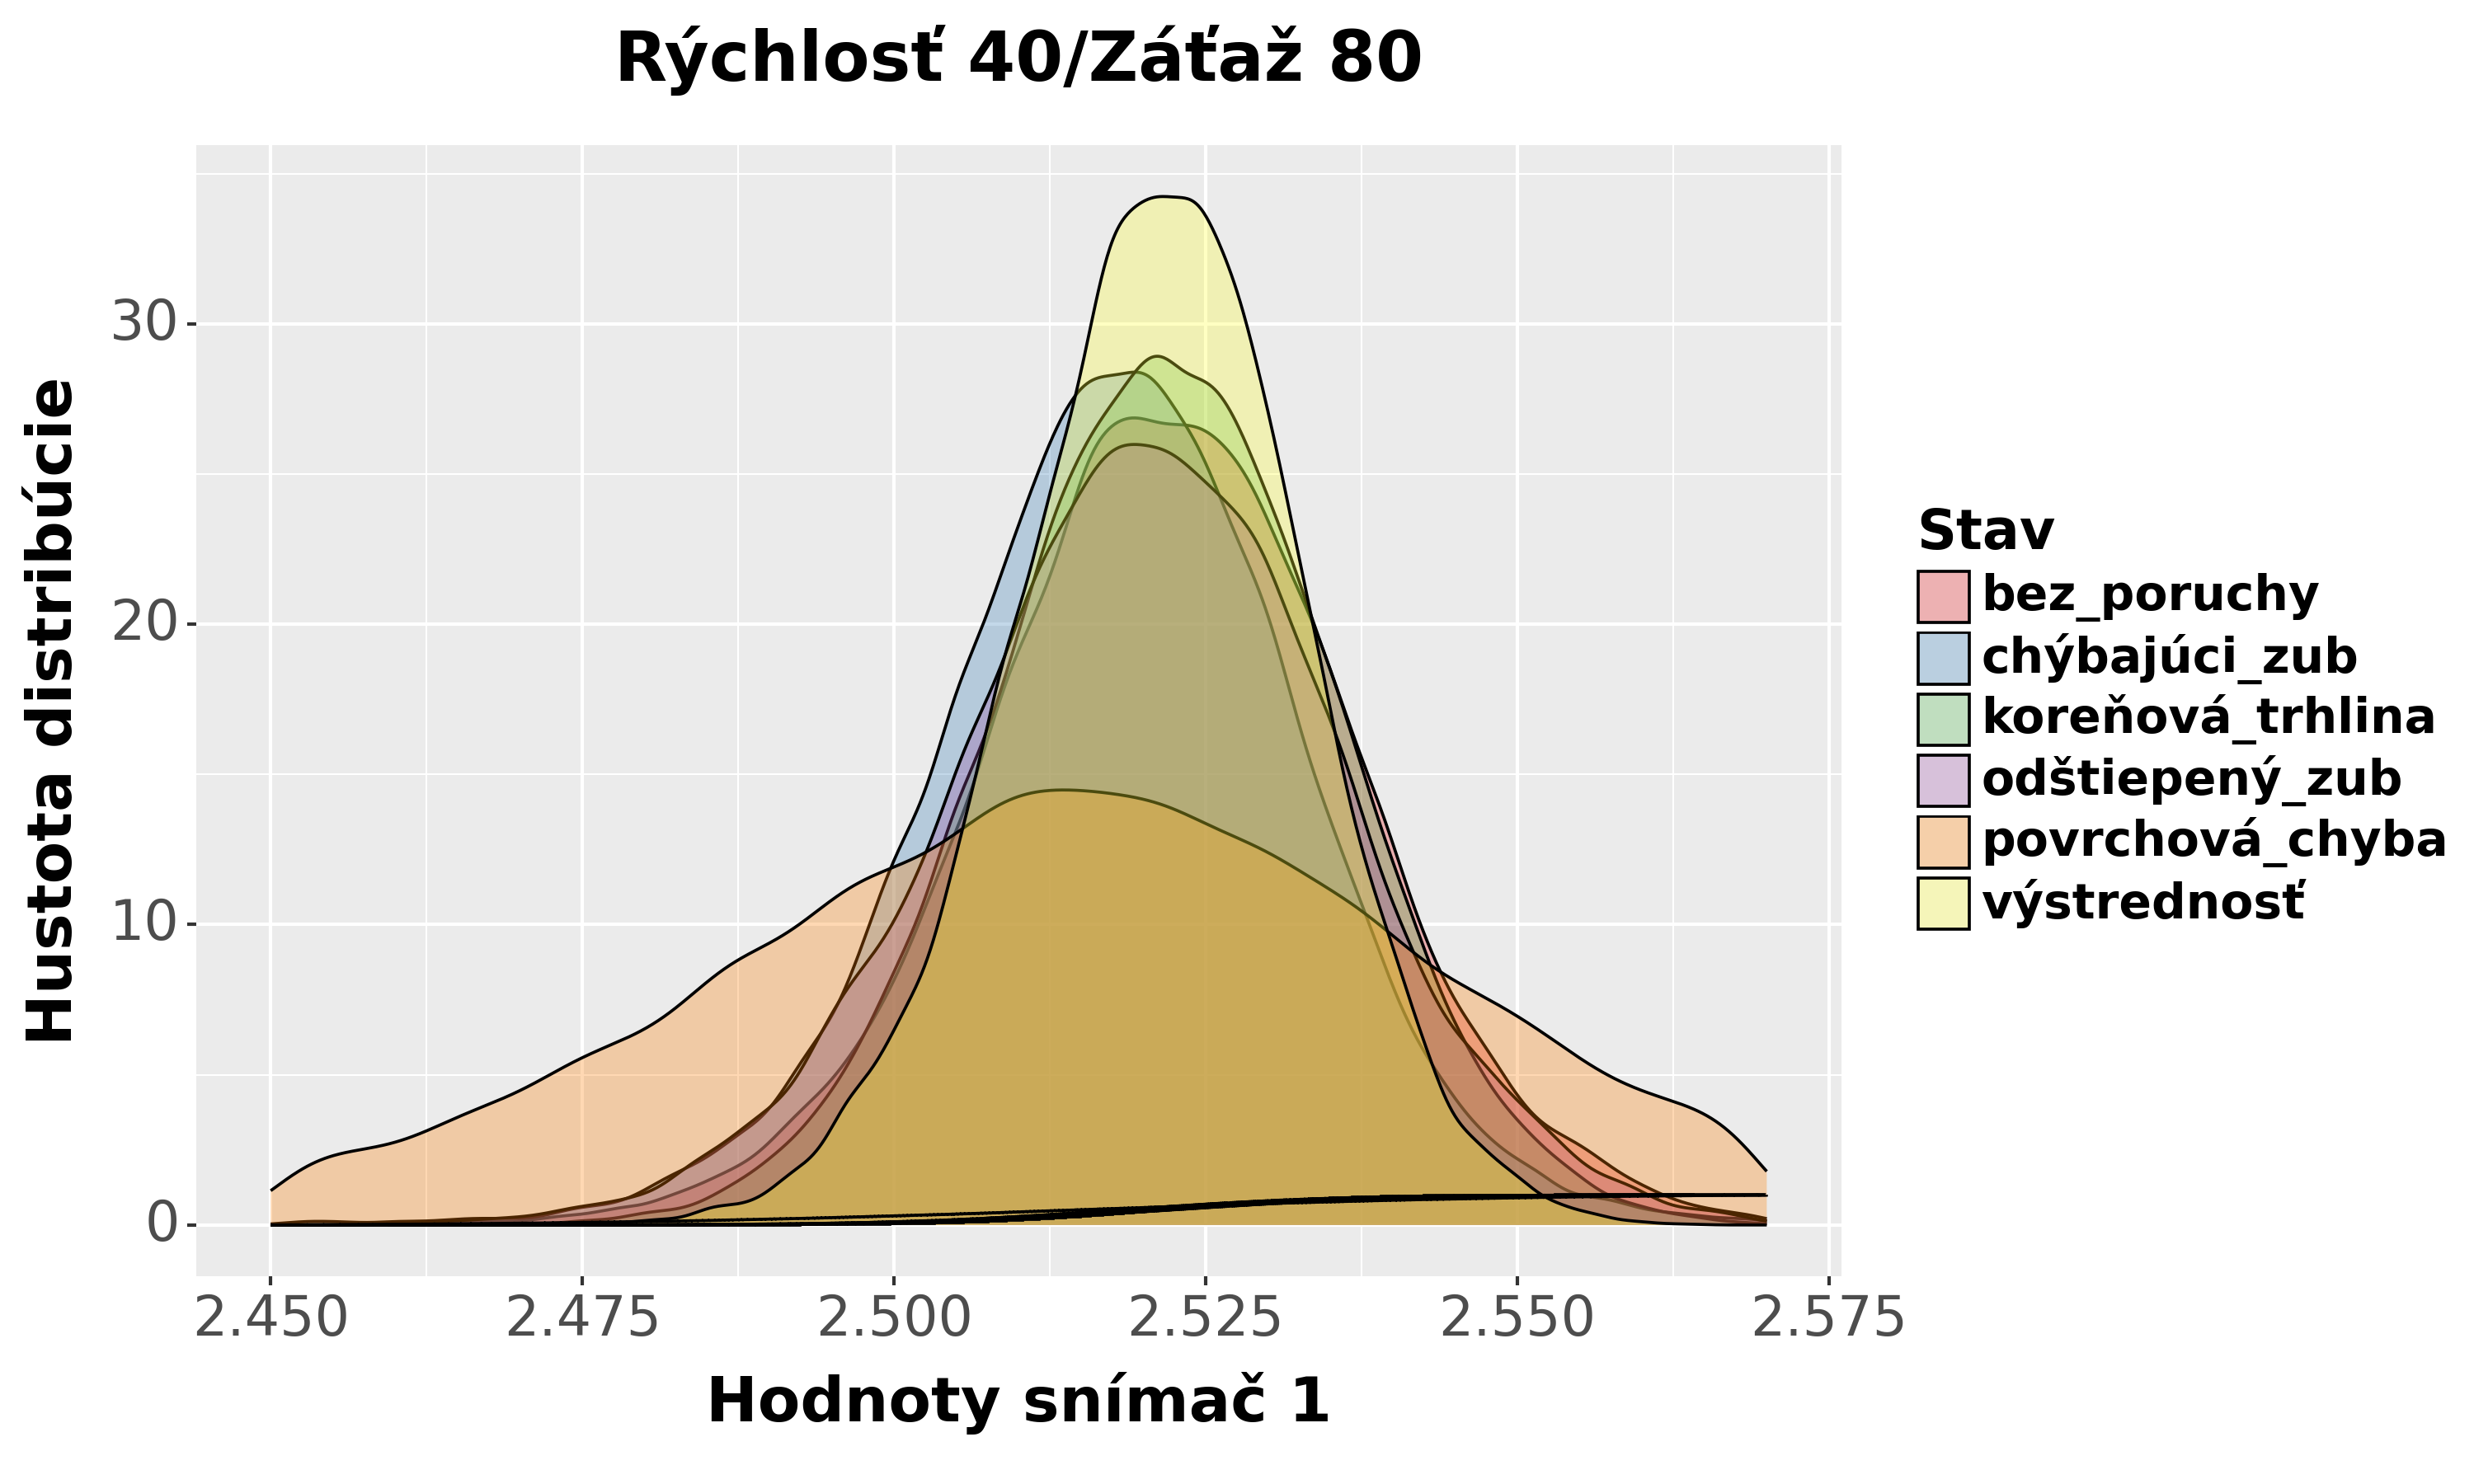

<Figure Size: (1500 x 900)>

In [14]:
display(ggplot(data=speedload_8_0, mapping=aes(x='sensor1', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 0') +
        labs(x='Hodnoty snímač 1', y='Hustota distribúcie', fill='Stav') + xlim(2.51,2.53) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_8_80, mapping=aes(x='sensor1', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 8.33/Záťaž 80') +
        labs(x='Hodnoty snímač 1', y='Hustota distribúcie', fill='Stav') + xlim(2.51,2.53) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_25_0, mapping=aes(x='sensor1', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25/Záťaž 0') +
        labs(x='Hodnoty snímač 1', y='Hustota distribúcie', fill='Stav') + xlim(2.49,2.55) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_25_80, mapping=aes(x='sensor1', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 25/Záťaž 80') +
        labs(x='Hodnoty snímač 1', y='Hustota distribúcie', fill='Stav') + xlim(2.49,2.55) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_40_0, mapping=aes(x='sensor1', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40/Záťaž 0') +
        labs(x='Hodnoty snímač 1', y='Hustota distribúcie', fill='Stav') + xlim(2.45,2.57) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))
display(ggplot(data=speedload_40_80, mapping=aes(x='sensor1', fill='Stav')) + geom_density(alpha=0.3) + stat_ecdf() +
        scale_fill_manual(values=colors) + ggtitle('Rýchlosť 40/Záťaž 80') +
        labs(x='Hodnoty snímač 1', y='Hustota distribúcie', fill='Stav') + xlim(2.45,2.57) +
        theme(
            figure_size=(10, 6),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))

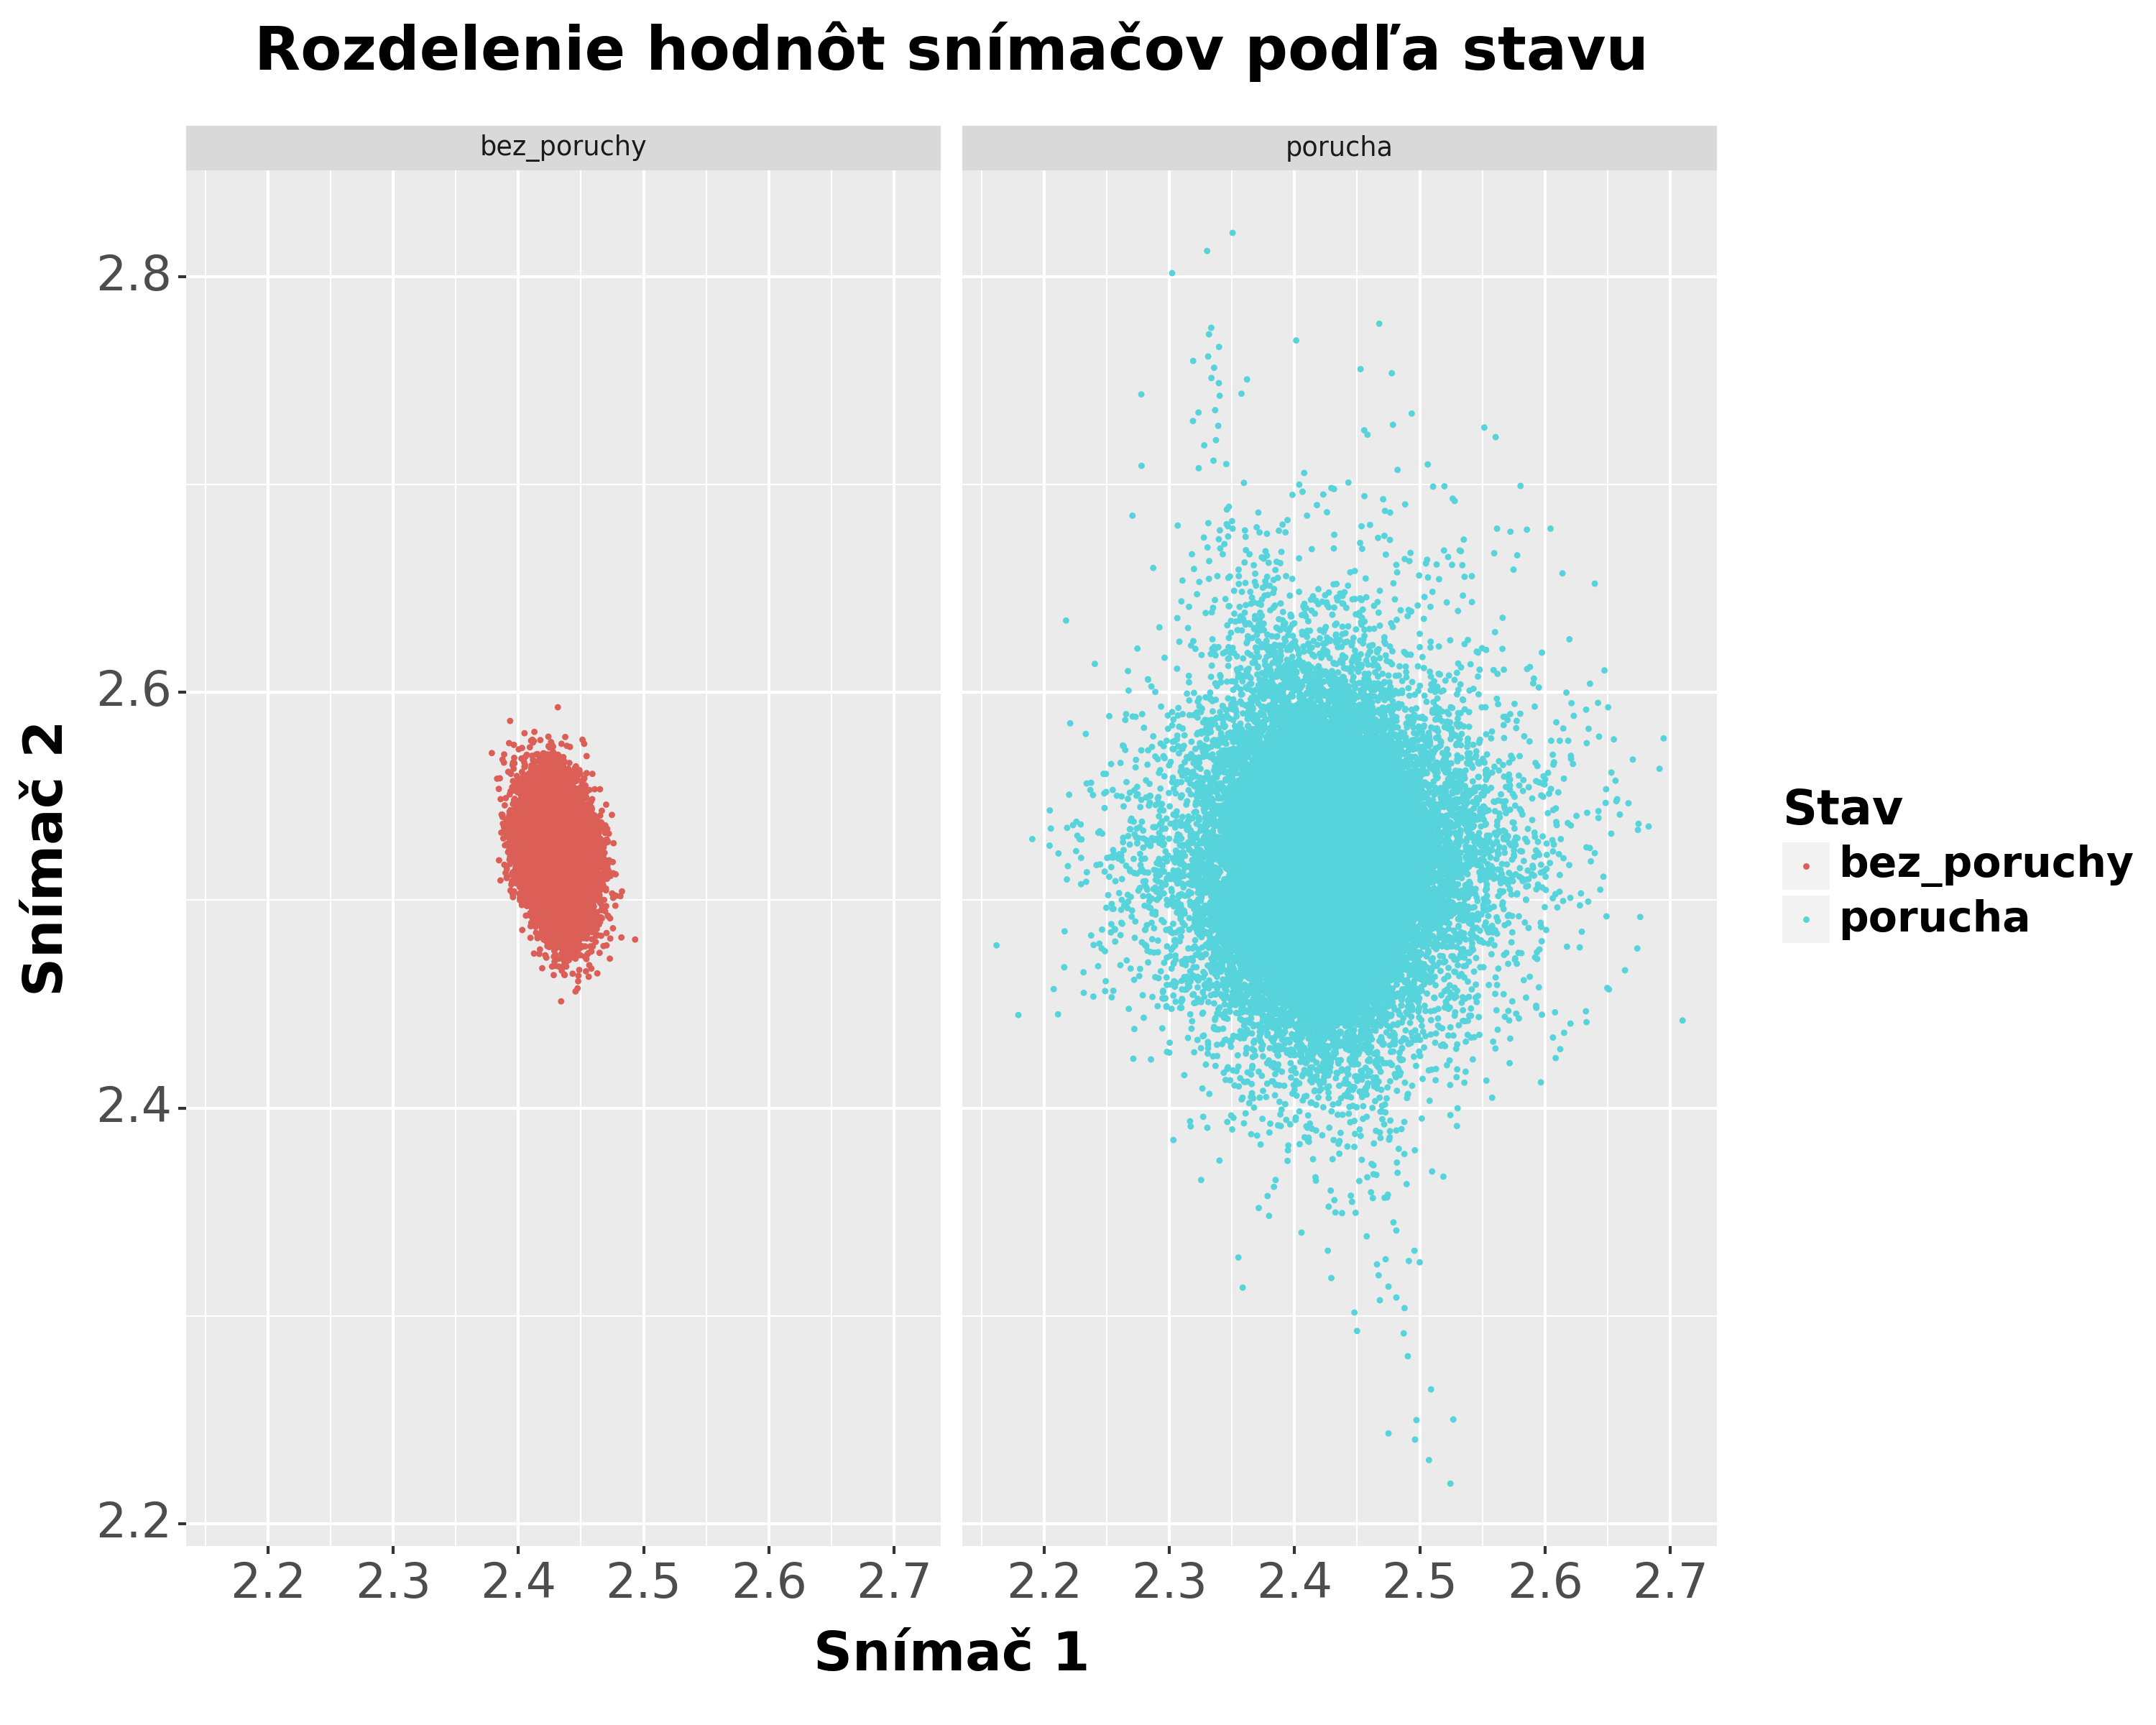

<Figure Size: (1500 x 1200)>

In [15]:
# Plot Stav column sensor values as bez_poruchy against other '~bez_poruchy' values
df_news = df.copy()
df_news['Stav'] = df_news['Stav'].apply(lambda x: 'bez_poruchy' if x == 'bez_poruchy' else 'porucha')
display(ggplot(df_news, aes(x='sensor2', y='sensor1', color='Stav')) + geom_point(size=0.2) +
        facet_wrap('~Stav') + ggtitle('Rozdelenie hodnôt snímačov podľa stavu') +
        labs(x='Snímač 1', y='Snímač 2', fill='Stav') +
        theme(
            figure_size=(10, 8),  # Width and height in inches
            dpi=150,  # Set the resolution of the plot
            axis_text=element_text(size=16),  # Axis tick labels
            axis_title=element_text(size=18, weight='bold'),  # Axis titles
            plot_title=element_text(size=20, weight='bold', ha='center'),  # Plot title
            legend_title=element_text(size=16, weight='bold'),  # Legend title
            legend_text=element_text(size=14, weight='bold')  # Legend text
        ))